# Load packages

In [1]:
library(Seurat)
library(dplyr)
library(Matrix)
library(future)
library(ggplot2)
library(CellChat)
library(patchwork)
library(ggVennDiagram)
library(stringr)
options(stringsAsFactors = FALSE)


Attaching SeuratObject

Attaching sp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:future’:

    %->%, %<-%


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘ggVennDiagram’


The following object is masked from ‘package:sp’:

    Polygon




Load modified CellChat functions for plotting specific interactions / cell types on the centrality heatmap.

In [2]:
source('cellchat_subset_functions.R')


Loading required package: RColorBrewer

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




# Load scRNAseq object

Load W13/15 scRNAseq object, and add transferred MERFISH annotations from the harmony integration.

In [3]:
in_vivo = readRDS('../data/in_vivo_w13_subset.rds') # this file can be obtained by subsetting the file overall_heart.rds to only 13 PCW

predictions = read.csv('../annotations/merfish_vent_to_scrnaseq_predicted_celltype.csv', row.names = 1) 
in_vivo[['merfish_vent_to_scrnaseq_label']] = predictions[rownames(in_vivo@meta.data),'merfish_vent_to_scrnaseq_label']


In [4]:
# specify cell type colors
celltype_vent_color = c('Bundle of His'='#cb4936', 'Hybrid vCM-LV'='#ff0000', 'Hybrid vCM-RV'='#5ac1b3', 
                       'Compact vCM-LV'='#1616c8', 'Compact vCM-RV'='#0D63A5', 'Compact vFibro'='#A12568', 'EPDC'='#F499C1', 
                       'Epicardial'='#F7C394', 'LEC'='#B2A157', 'Neuronal-like'='#ade87c', 
                       'Pericyte'='#000000', 'Proliferating Compact vCM-LV'='#03C4A1', 
                       'Proliferating Trabecular vCM-LV'='#bb4316', 'Proliferating vCM-RV'='#7382BC', 
                       'Proliferating vFibro'='#F0E442', 'Purkinje Fiber'='#3B185F', 
                       'Trabecular vCM-LV'='#0d6c0d', 'Trabecular vCM-RV'='#FEC260', 'Trabecular vFibro'='#FD7014', 
                       'VE'='#a67063', 'VEC'='#1B9B8A', 'VIC'='#D0EBE7', 'VSMC'='#713045', 'WBC'='#F6E0EA', 
                       'avCM-LV'='#AD6D28', 'avCM-RV'='#EAB67D', 'vCM-RV'='#5ac1b3', 'vEndocardial'='#EE4590')


# Inner-LV

For each community, we consider interactions between cell types that represent at least 3.5% of that community in the MERFISH dataset.

In [5]:
community_celltypes = c('Trabecular vCM-LV', 'Proliferating Trabecular vCM-LV', 'vEndocardial', 'Trabecular vFibro')

cellchat_inner_lv = createCellChat(object = subset(in_vivo, subset = merfish_vent_to_scrnaseq_label %in% community_celltypes),
                                   group.by = "merfish_vent_to_scrnaseq_label")


Create a CellChat object from a Seurat object



The `data` slot in the default assay is used. The default assay is RNA 
The `meta.data` slot in the Seurat object is used as cell meta information 


Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  Proliferating Trabecular vCM-LV Trabecular vCM-LV Trabecular vFibro vEndocardial 


We use CellChat's Human databased on receptor ligand interactions, and add one additional interaction between NRG1 and ERBB2.

In [6]:
CellChatDB <- CellChatDB.human 
# Add missing NRG1 - ERBB2 interaction to CellChat database
CellChatDB$interaction['NRG1_ERBB2',] = c('NRG1_ERBB2','NRG','NRG1','ERBB2','','','','','KEGG: hsa04012','Secreted Signaling','NRG1 - ERBB2')
CellChatDB.use = CellChatDB 
cellchat_inner_lv@DB <- CellChatDB.use


The CellChat object is processed following their vignette:

https://htmlpreview.github.io/?https://github.com/sqjin/CellChat/blob/master/tutorial/CellChat-vignette.html

In [7]:
cellchat_inner_lv <- subsetData(cellchat_inner_lv)
cellchat_inner_lv <- identifyOverExpressedGenes(cellchat_inner_lv)
cellchat_inner_lv <- identifyOverExpressedInteractions(cellchat_inner_lv)
cellchat_inner_lv <- computeCommunProb(cellchat_inner_lv, population.size=TRUE)
cellchat_inner_lv <- filterCommunication(cellchat_inner_lv)
cellchat_inner_lv <- computeCommunProbPathway(cellchat_inner_lv)
cellchat_inner_lv <- aggregateNet(cellchat_inner_lv)
cellchat_inner_lv <- netAnalysis_computeCentrality(cellchat_inner_lv, slot.name = "netP") 


Visualizing the number interactions between cell types in the community.

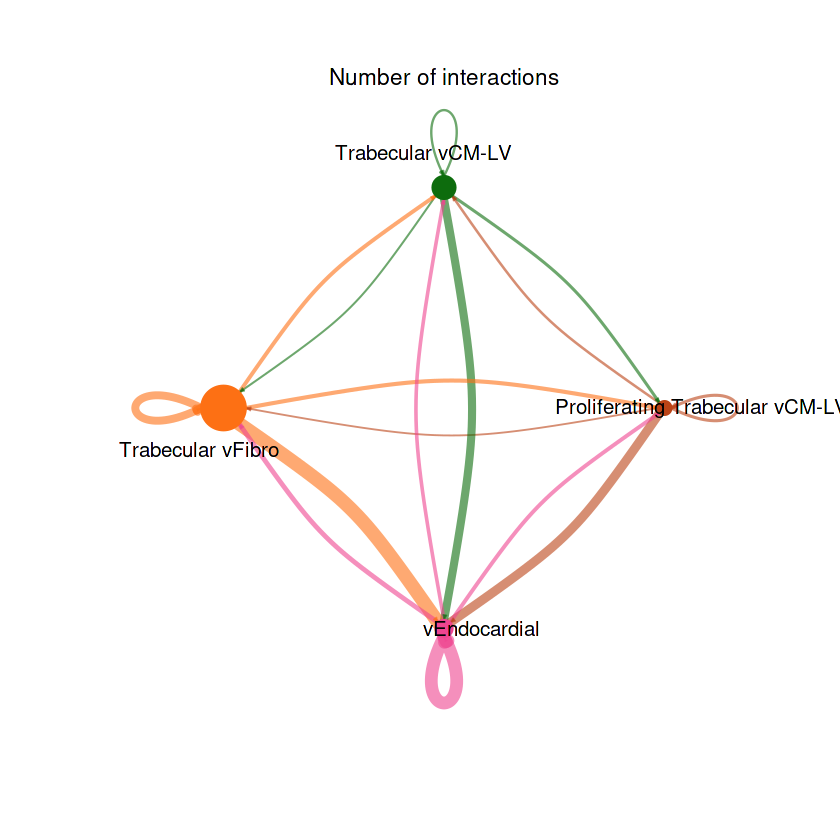

Saving 6.67 x 6.67 in image



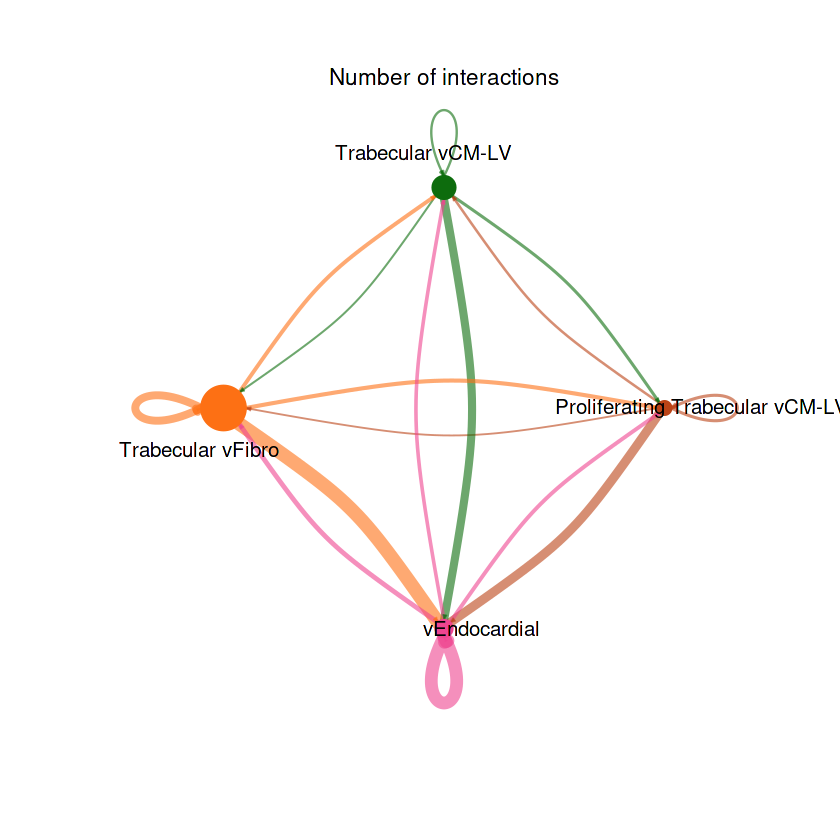

In [8]:
groupSize <- as.numeric(table(cellchat_inner_lv@idents))

netVisual_circle(cellchat_inner_lv@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Number of interactions", color.use = celltype_vent_color[levels(cellchat_inner_lv@idents)])
ggsave('../figures/Ext_Dat_Fig9/cellchat_inner_lv_n_inter.pdf')


Visualizing the weight of interactions between cell types in the community. Interaction weight is based on the expression of the ligand and receptor genes.

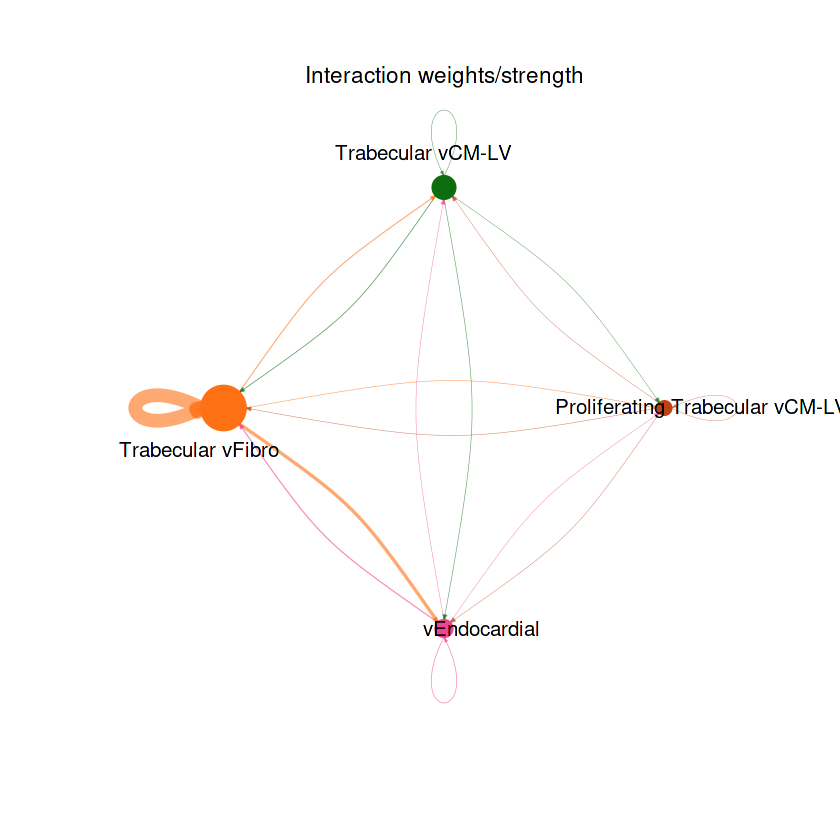

Saving 6.67 x 6.67 in image



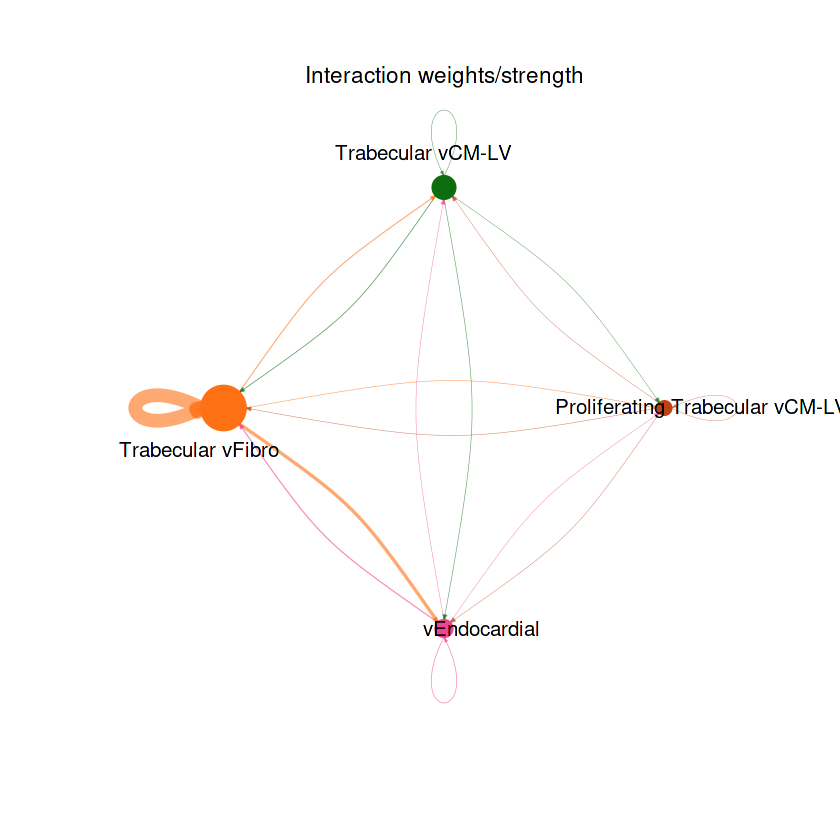

In [9]:
netVisual_circle(cellchat_inner_lv@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Interaction weights/strength", color.use = celltype_vent_color[levels(cellchat_inner_lv@idents)])
ggsave('../figures/Fig4/cellchat_inner_lv_inter_weights.pdf')


Visualize the incoming / outgoing interactions for each cell type. Interactions are grouped by pathway, so all the interaction probabilities are summed for a given pathway. The summed interaction probabilities for a pathway are scaled relative to all the cell types.

PNG 
  2

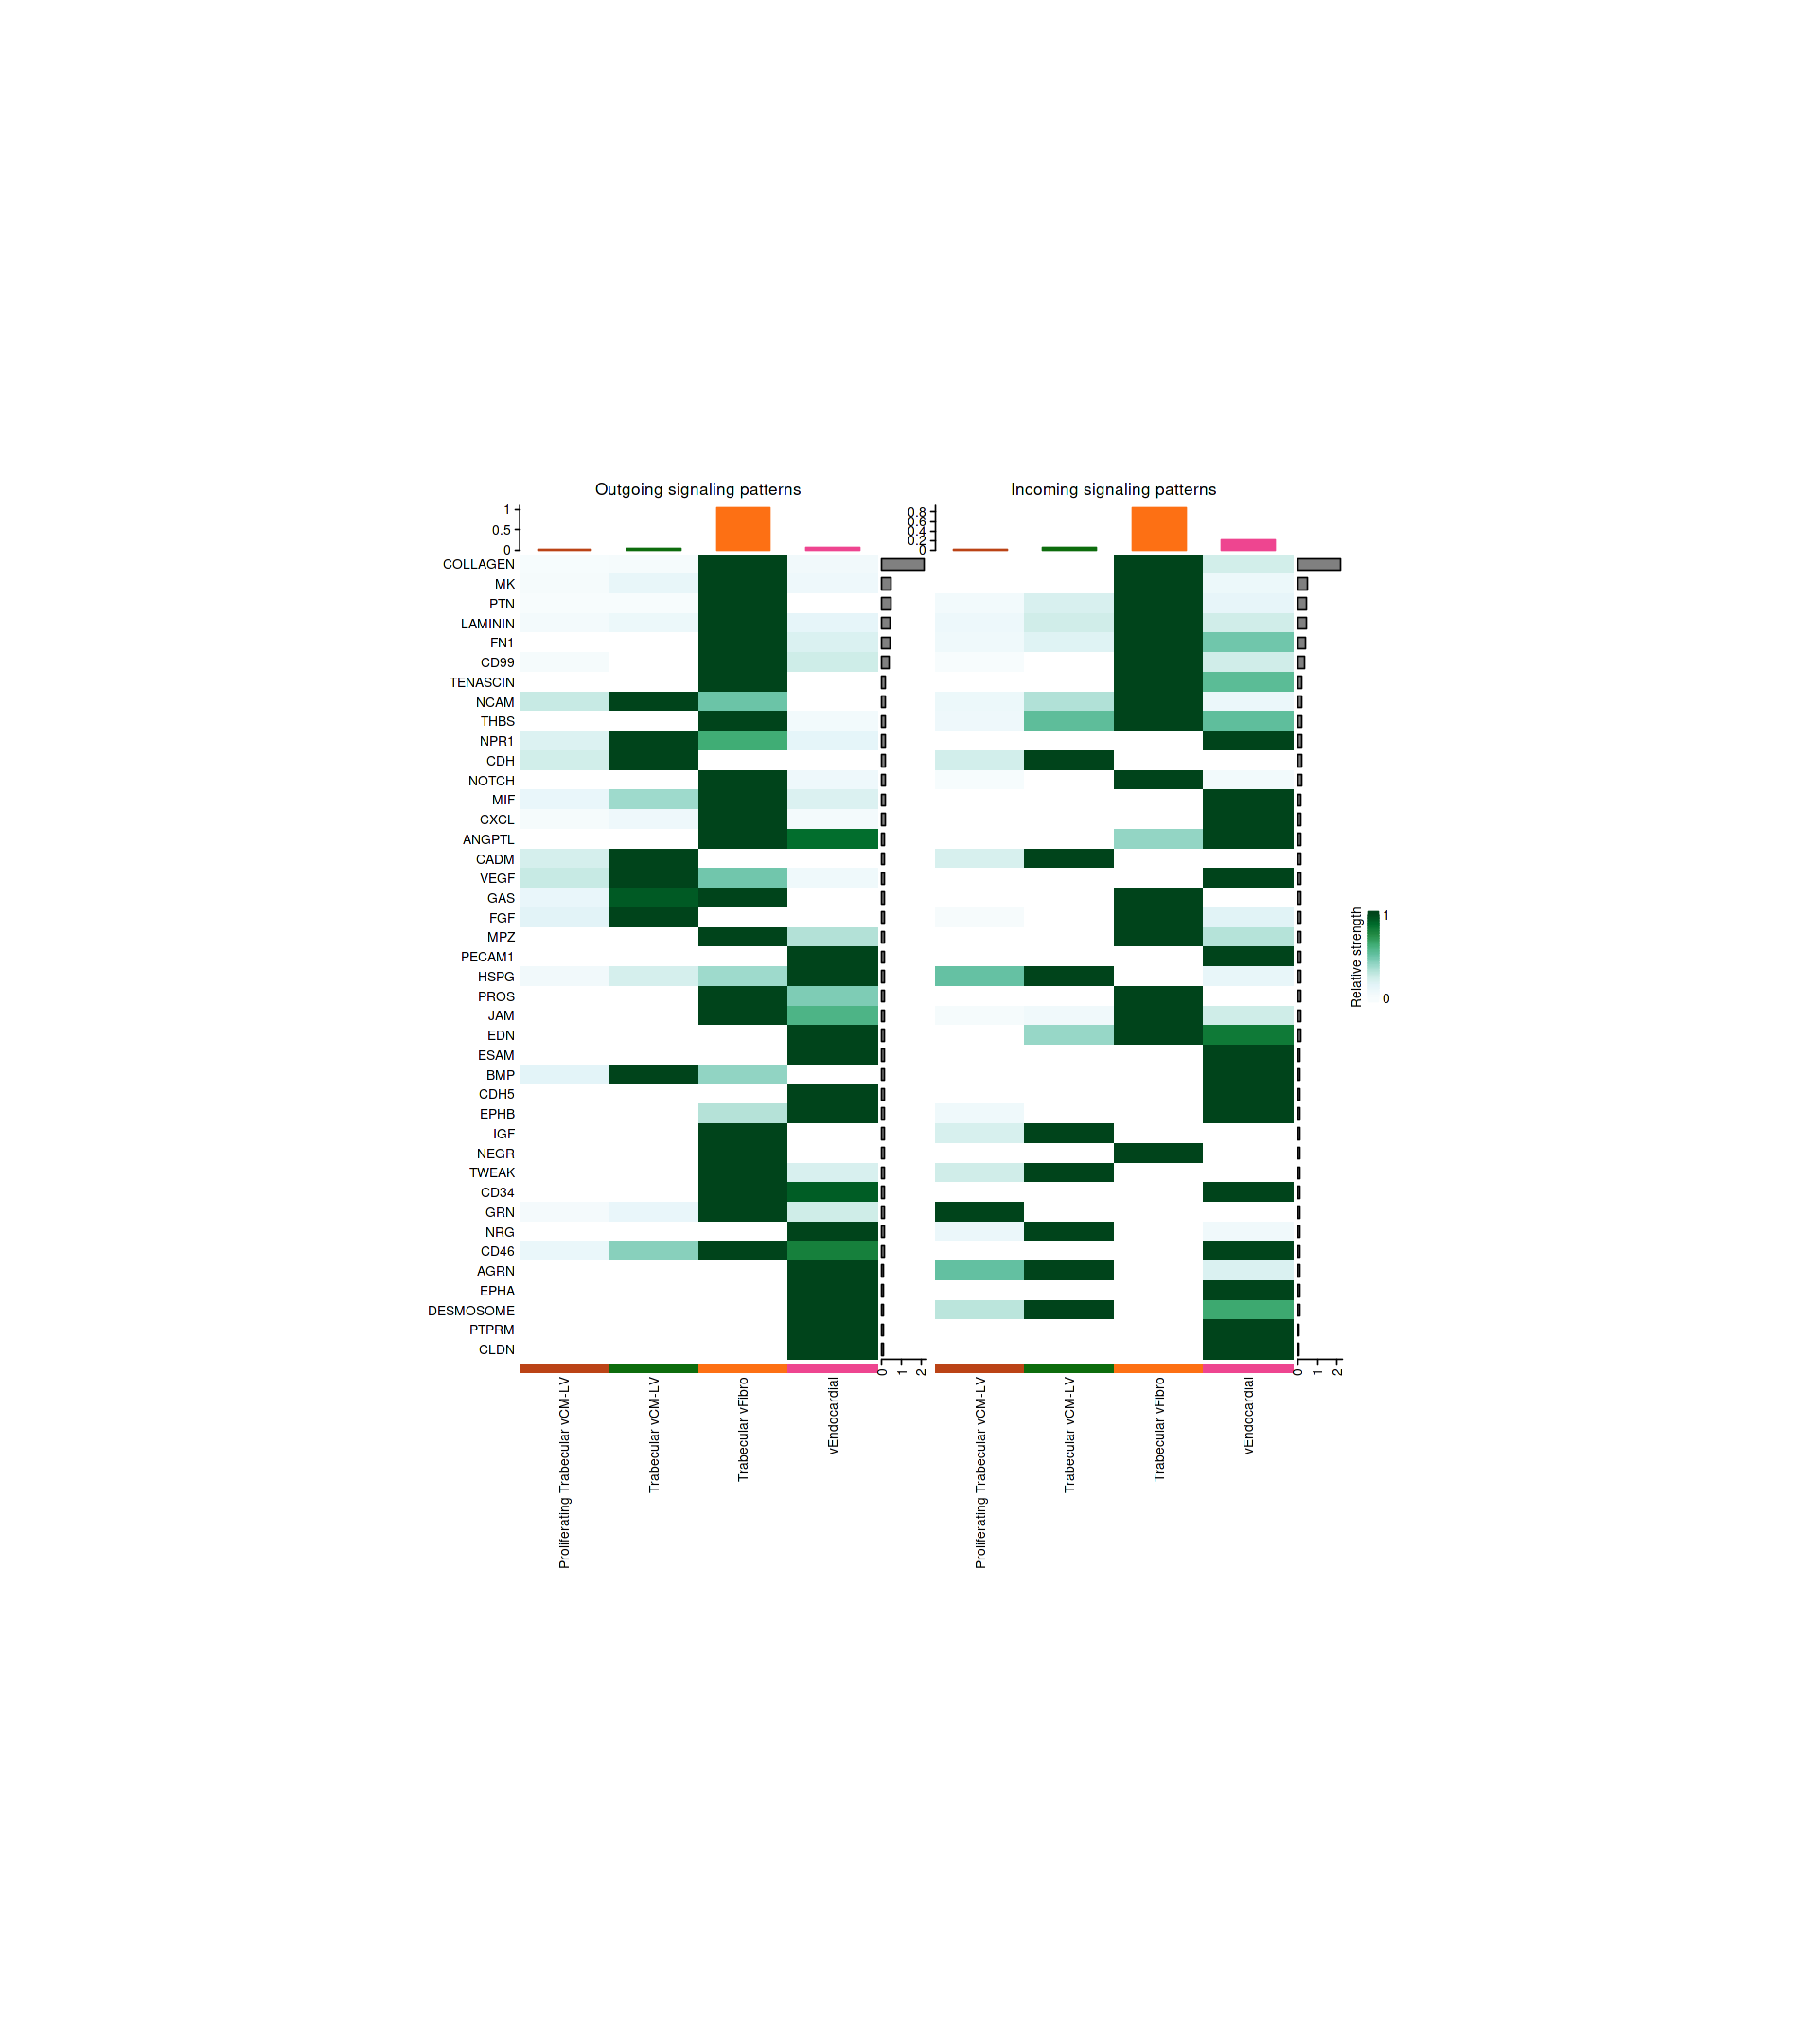

In [10]:
# Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
w = 8
h = 18 
ht1 <- netAnalysis_signalingRole_heatmap(cellchat_inner_lv, pattern = "outgoing", width=w, height=h, 
                                         color.use = celltype_vent_color[levels(cellchat_inner_lv@idents)])
ht2 <- netAnalysis_signalingRole_heatmap(cellchat_inner_lv, pattern = "incoming", width=w, height=h, 
                                         color.use = celltype_vent_color[levels(cellchat_inner_lv@idents)])

options(repr.plot.width = 2*w, repr.plot.height = h)
ht1 + ht2
options(repr.plot.width = 7, repr.plot.height = 7)

pdf(paste0('../figures/Ext_Dat_Fig9/cellchat_inner_lv_centrality_heatmap.pdf'), width=2*w, height=h)
ht1 + ht2
dev.off()


Subsetted incoming interaction heatmap that only shows the cardiomyocyte cell types.

PNG 
  2

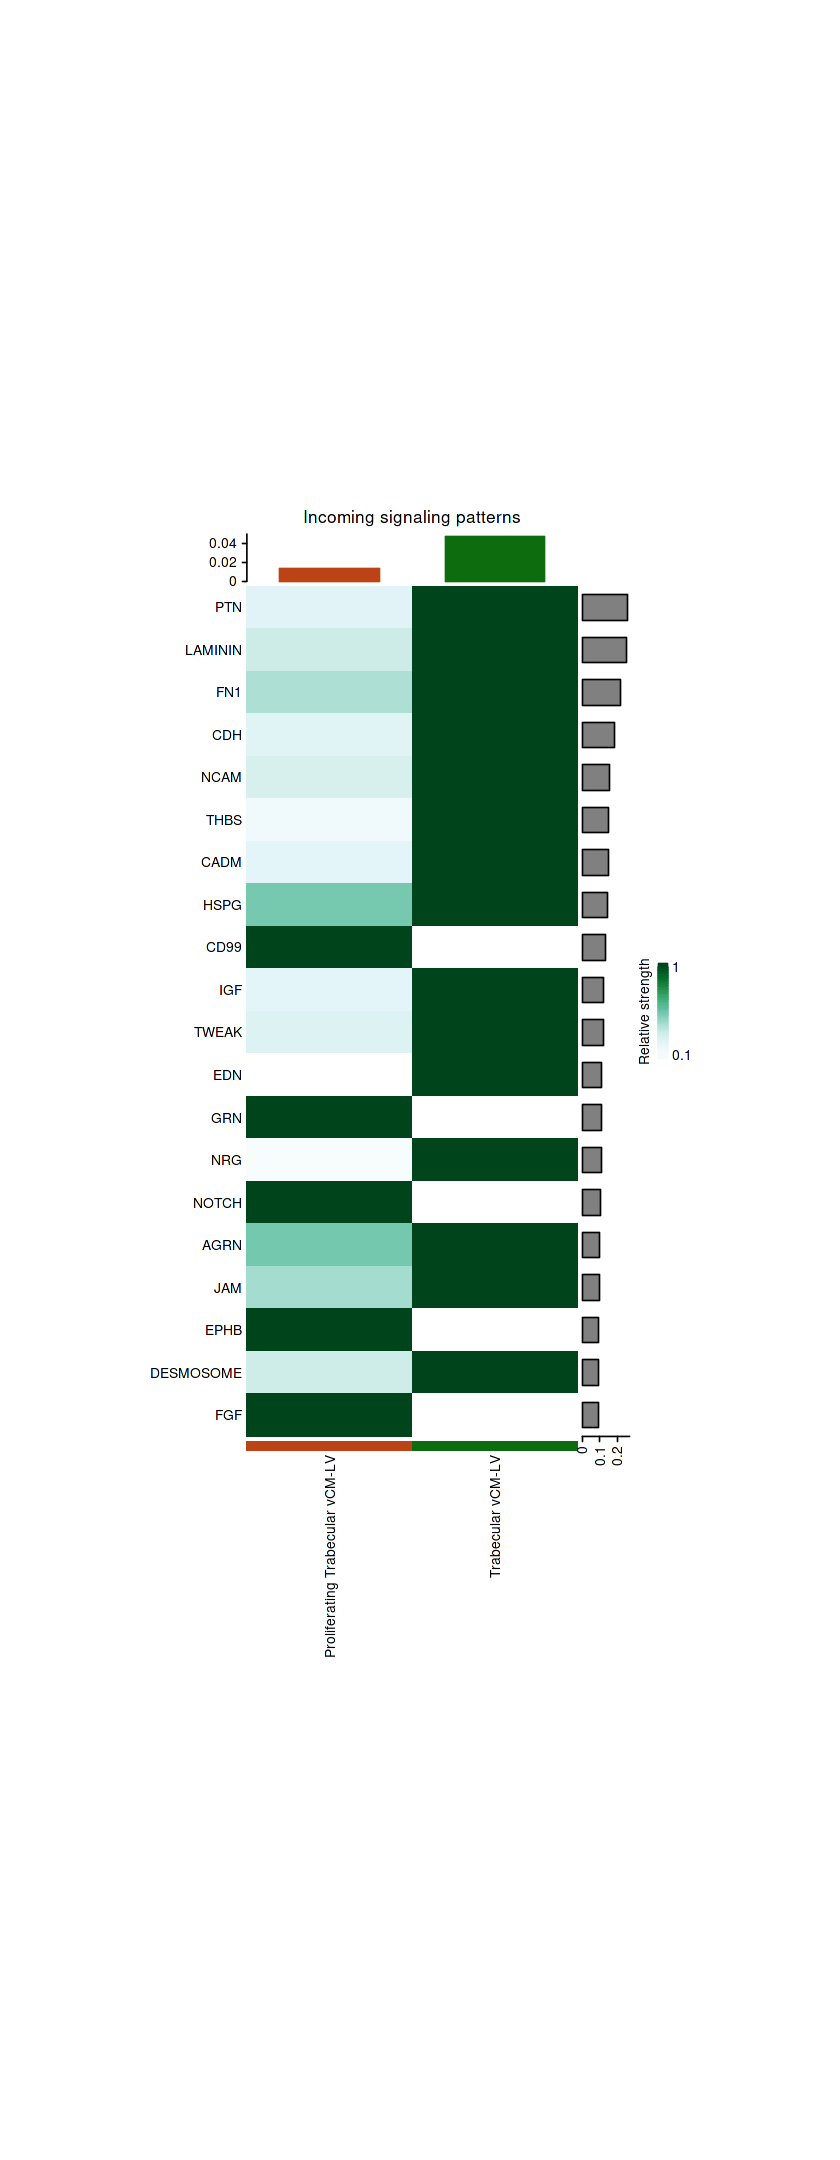

In [11]:
w = 7
h = 18 
options(repr.plot.width = w, repr.plot.height = h)
celltypes = c('Proliferating Trabecular vCM-LV','Trabecular vCM-LV')
ht1 = subset_netAnalysis_signalingRole_heatmap(cellchat_inner_lv, celltypes=celltypes, pattern = "incoming", width=w, height=h,
                                               color.use = celltype_vent_color[levels(cellchat_inner_lv@idents)[levels(cellchat_inner_lv@idents) %in% celltypes]])
ht1
options(repr.plot.width = 7, repr.plot.height = 7)

pdf('../figures/Ext_Dat_Fig10/cellchat_inner_lv_centrality_heatmap_incoming_cm.pdf', width=w, height=h)
ht1 
dev.off()


In [12]:
saveRDS(cellchat_inner_lv, '../data/cellchat/cellchat_inner_lv.rds')
# saveRDS(cellchat_inner_lv, '../data/cellchat/cellchat_inner_lv.rds')


Comparing communications on a single object 




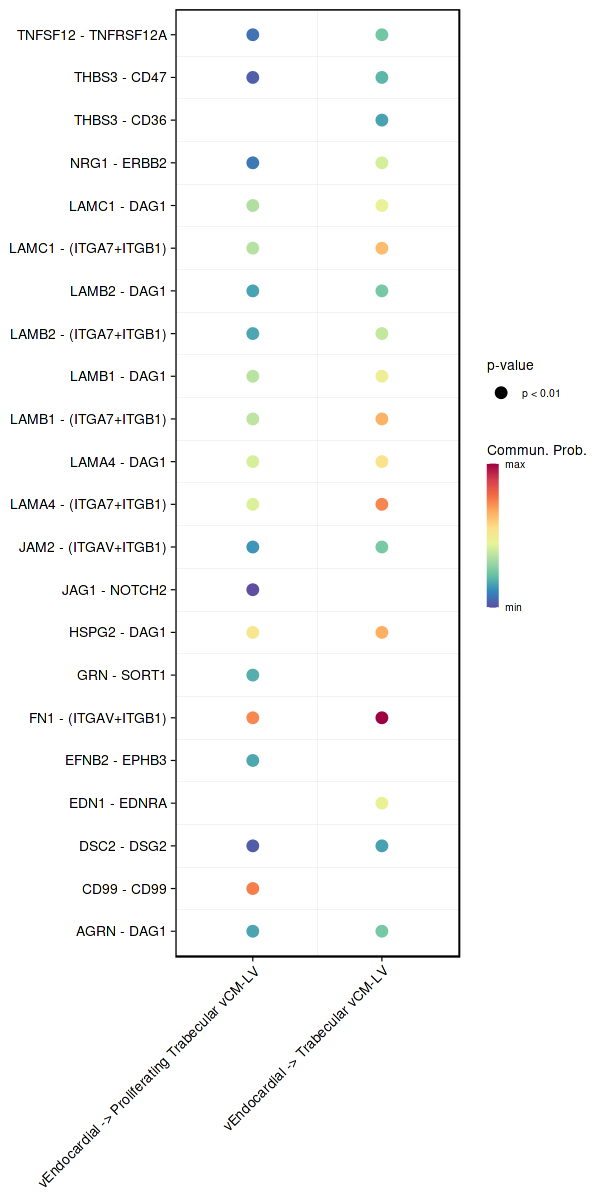

In [13]:
w = 5
h = 10 # all 
options(repr.plot.width = w, repr.plot.height = h)

netVisual_bubble(cellchat_inner_lv, angle.x = 45, sources.use = ('vEndocardial'), 
                 targets.use = c('Trabecular vCM-LV', 'Proliferating Trabecular vCM-LV'))
ggsave(paste0('/volume/Plots/cellchat/merfish_ventricle_communities/celltype_vent3/Trabecular-LV/dotplot.pdf'), width=w, height=h)

options(repr.plot.width = 7, repr.plot.height = 7)


# Mid-LV

Repeat analysis for Mid-LV community.

In [14]:
# Include cell types that represent at least 3.5% of the community in the MERFISH data
community_celltypes = c('Hybrid vCM-LV', 'Compact vCM-LV', 'Proliferating Compact vCM-LV', 'VE', 'Trabecular vCM-LV', 
                        'Proliferating Trabecular vCM-LV', 'Trabecular vFibro', 'Pericyte', 'Compact vFibro')

cellchat_mid_lv = createCellChat(object = subset(in_vivo, subset = merfish_vent_to_scrnaseq_label %in% community_celltypes),
                                 group.by = "merfish_vent_to_scrnaseq_label")


Create a CellChat object from a Seurat object



The `data` slot in the default assay is used. The default assay is RNA 
The `meta.data` slot in the Seurat object is used as cell meta information 


Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  Compact vCM-LV Compact vFibro Hybrid vCM-LV Pericyte Proliferating Compact vCM-LV Proliferating Trabecular vCM-LV Trabecular vCM-LV Trabecular vFibro VE 


In [15]:
CellChatDB <- CellChatDB.human 
# Add missing NRG1 - ERBB2 interaction to CellChat database
CellChatDB$interaction['NRG1_ERBB2',] = c('NRG1_ERBB2','NRG','NRG1','ERBB2','','','','','KEGG: hsa04012','Secreted Signaling','NRG1 - ERBB2')
CellChatDB.use = CellChatDB 
cellchat_mid_lv@DB <- CellChatDB.use


In [16]:
cellchat_mid_lv <- subsetData(cellchat_mid_lv)
cellchat_mid_lv <- identifyOverExpressedGenes(cellchat_mid_lv)
cellchat_mid_lv <- identifyOverExpressedInteractions(cellchat_mid_lv)
cellchat_mid_lv <- computeCommunProb(cellchat_mid_lv, population.size=TRUE)
cellchat_mid_lv <- filterCommunication(cellchat_mid_lv)
cellchat_mid_lv <- computeCommunProbPathway(cellchat_mid_lv)
cellchat_mid_lv <- aggregateNet(cellchat_mid_lv)
cellchat_mid_lv <- netAnalysis_computeCentrality(cellchat_mid_lv, slot.name = "netP") 


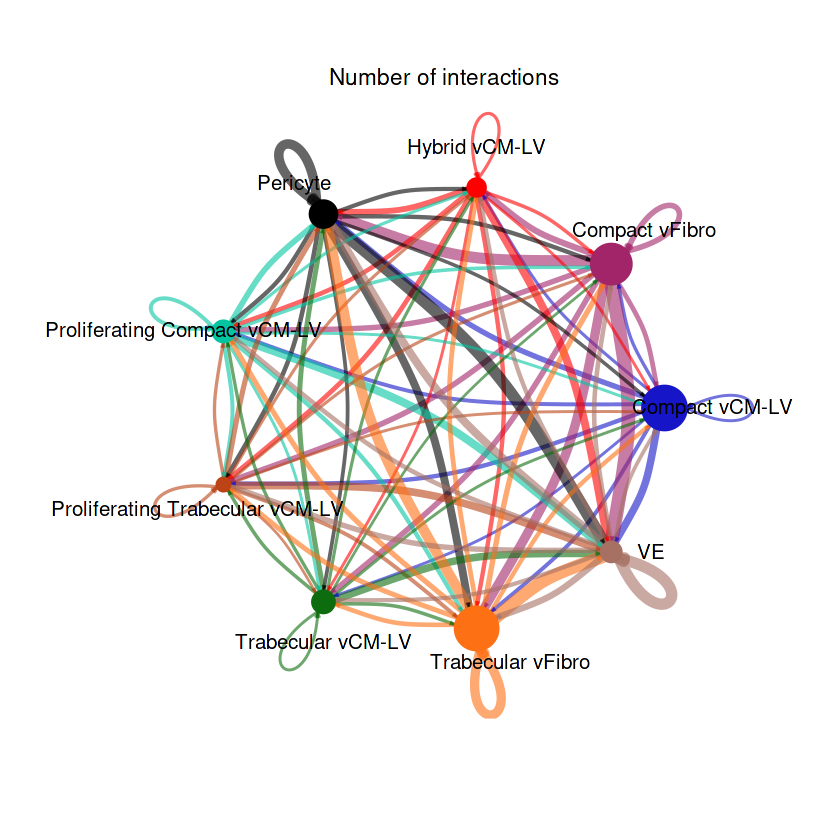

Saving 6.67 x 6.67 in image



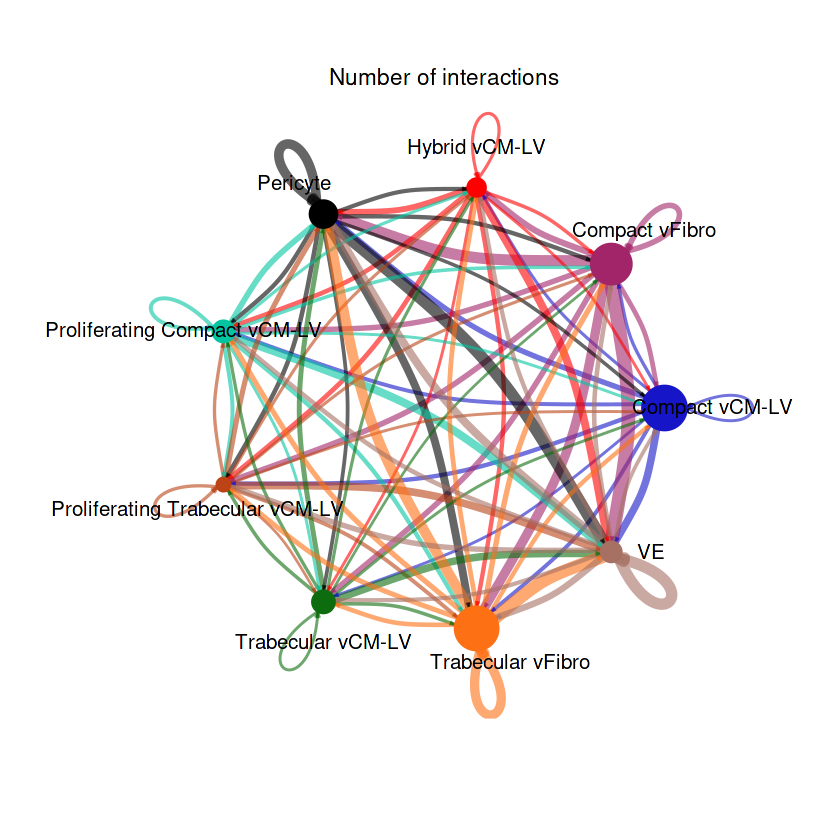

In [17]:
groupSize <- as.numeric(table(cellchat_mid_lv@idents))

netVisual_circle(cellchat_mid_lv@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Number of interactions", color.use = celltype_vent_color[levels(cellchat_mid_lv@idents)])
ggsave('../figures/Ext_Dat_Fig9/cellchat_mid_lv_n_inter.pdf')


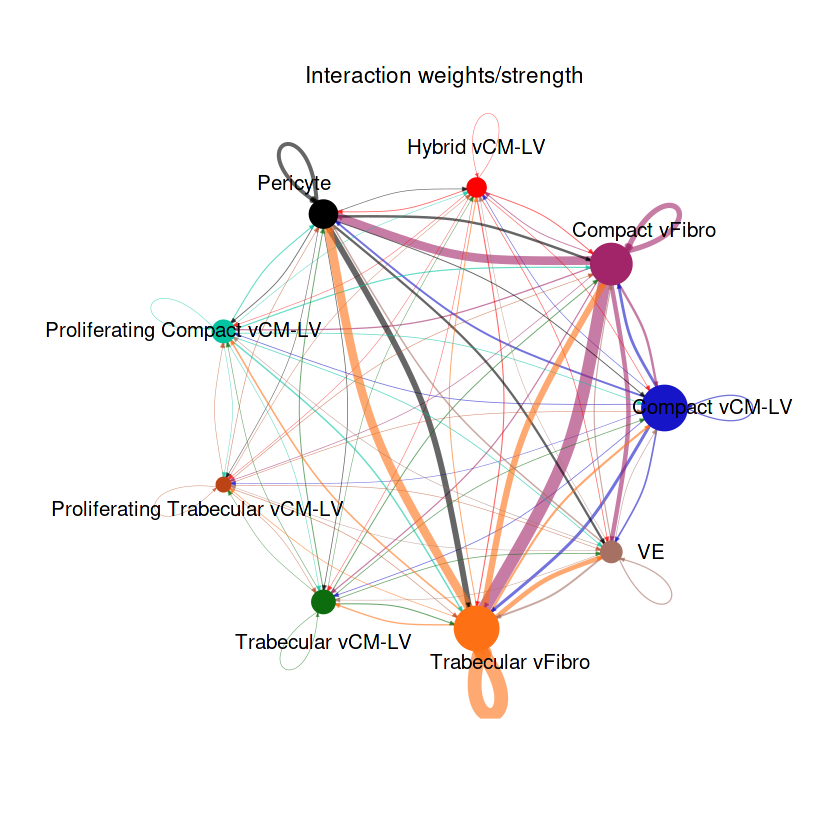

Saving 6.67 x 6.67 in image



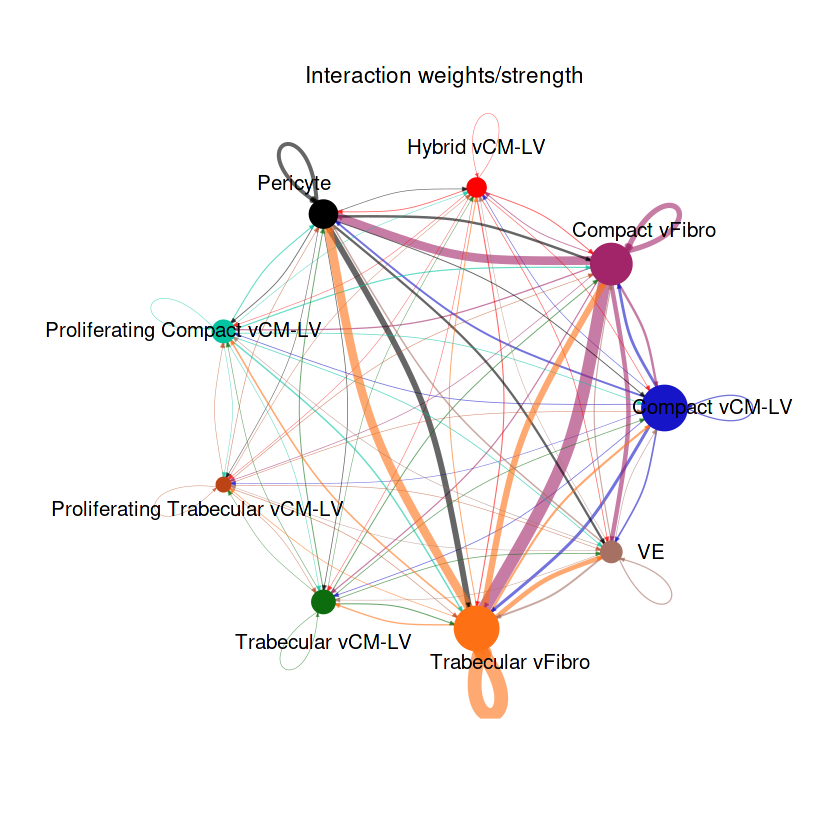

In [18]:
netVisual_circle(cellchat_mid_lv@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Interaction weights/strength", color.use = celltype_vent_color[levels(cellchat_mid_lv@idents)])
ggsave('../figures/Fig4/cellchat_mid_lv_inter_weights.pdf')


PNG 
  2

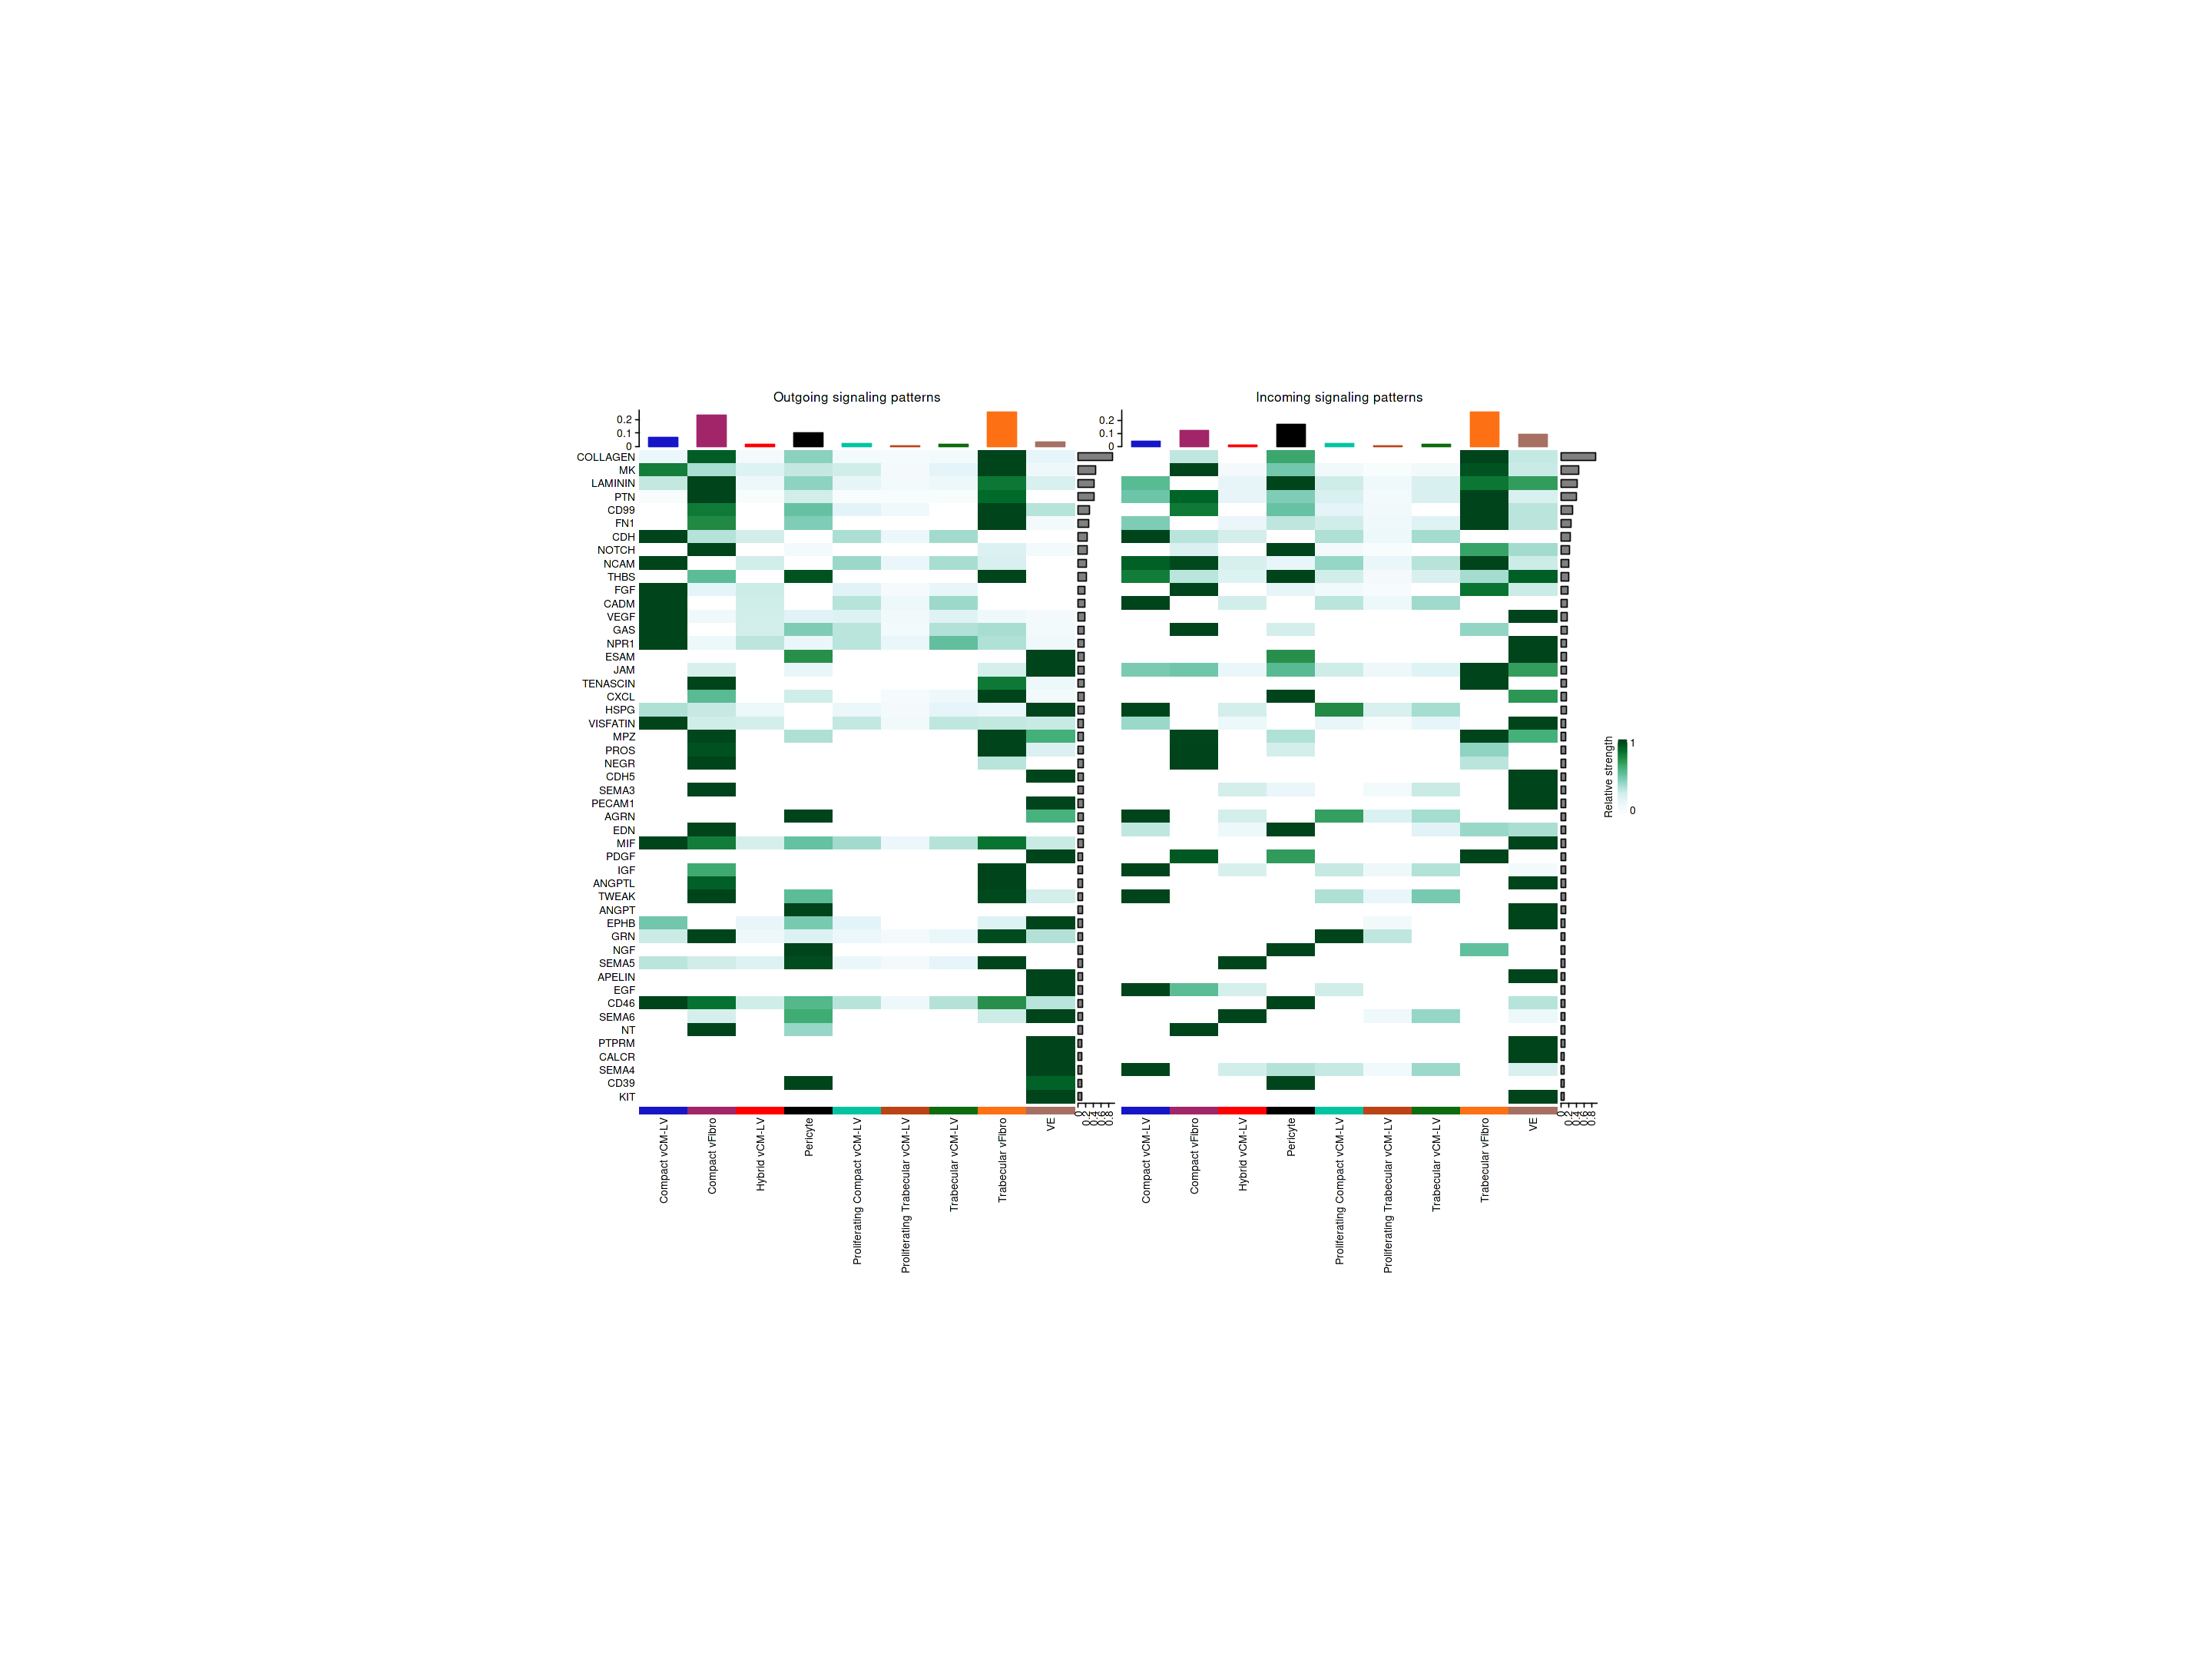

In [19]:
# Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
w = 12
h = 18 
ht1 <- netAnalysis_signalingRole_heatmap(cellchat_mid_lv, pattern = "outgoing", width=w, height=h, 
                                         color.use = celltype_vent_color[levels(cellchat_mid_lv@idents)])
ht2 <- netAnalysis_signalingRole_heatmap(cellchat_mid_lv, pattern = "incoming", width=w, height=h, 
                                         color.use = celltype_vent_color[levels(cellchat_mid_lv@idents)])

options(repr.plot.width = 2*w, repr.plot.height = h)
ht1 + ht2
options(repr.plot.width = 7, repr.plot.height = 7)

pdf(paste0('../figures/Ext_Dat_Fig9/cellchat_mid_lv_centrality_heatmap.pdf'), width=2*w, height=h)
ht1 + ht2
dev.off()


PNG 
  2

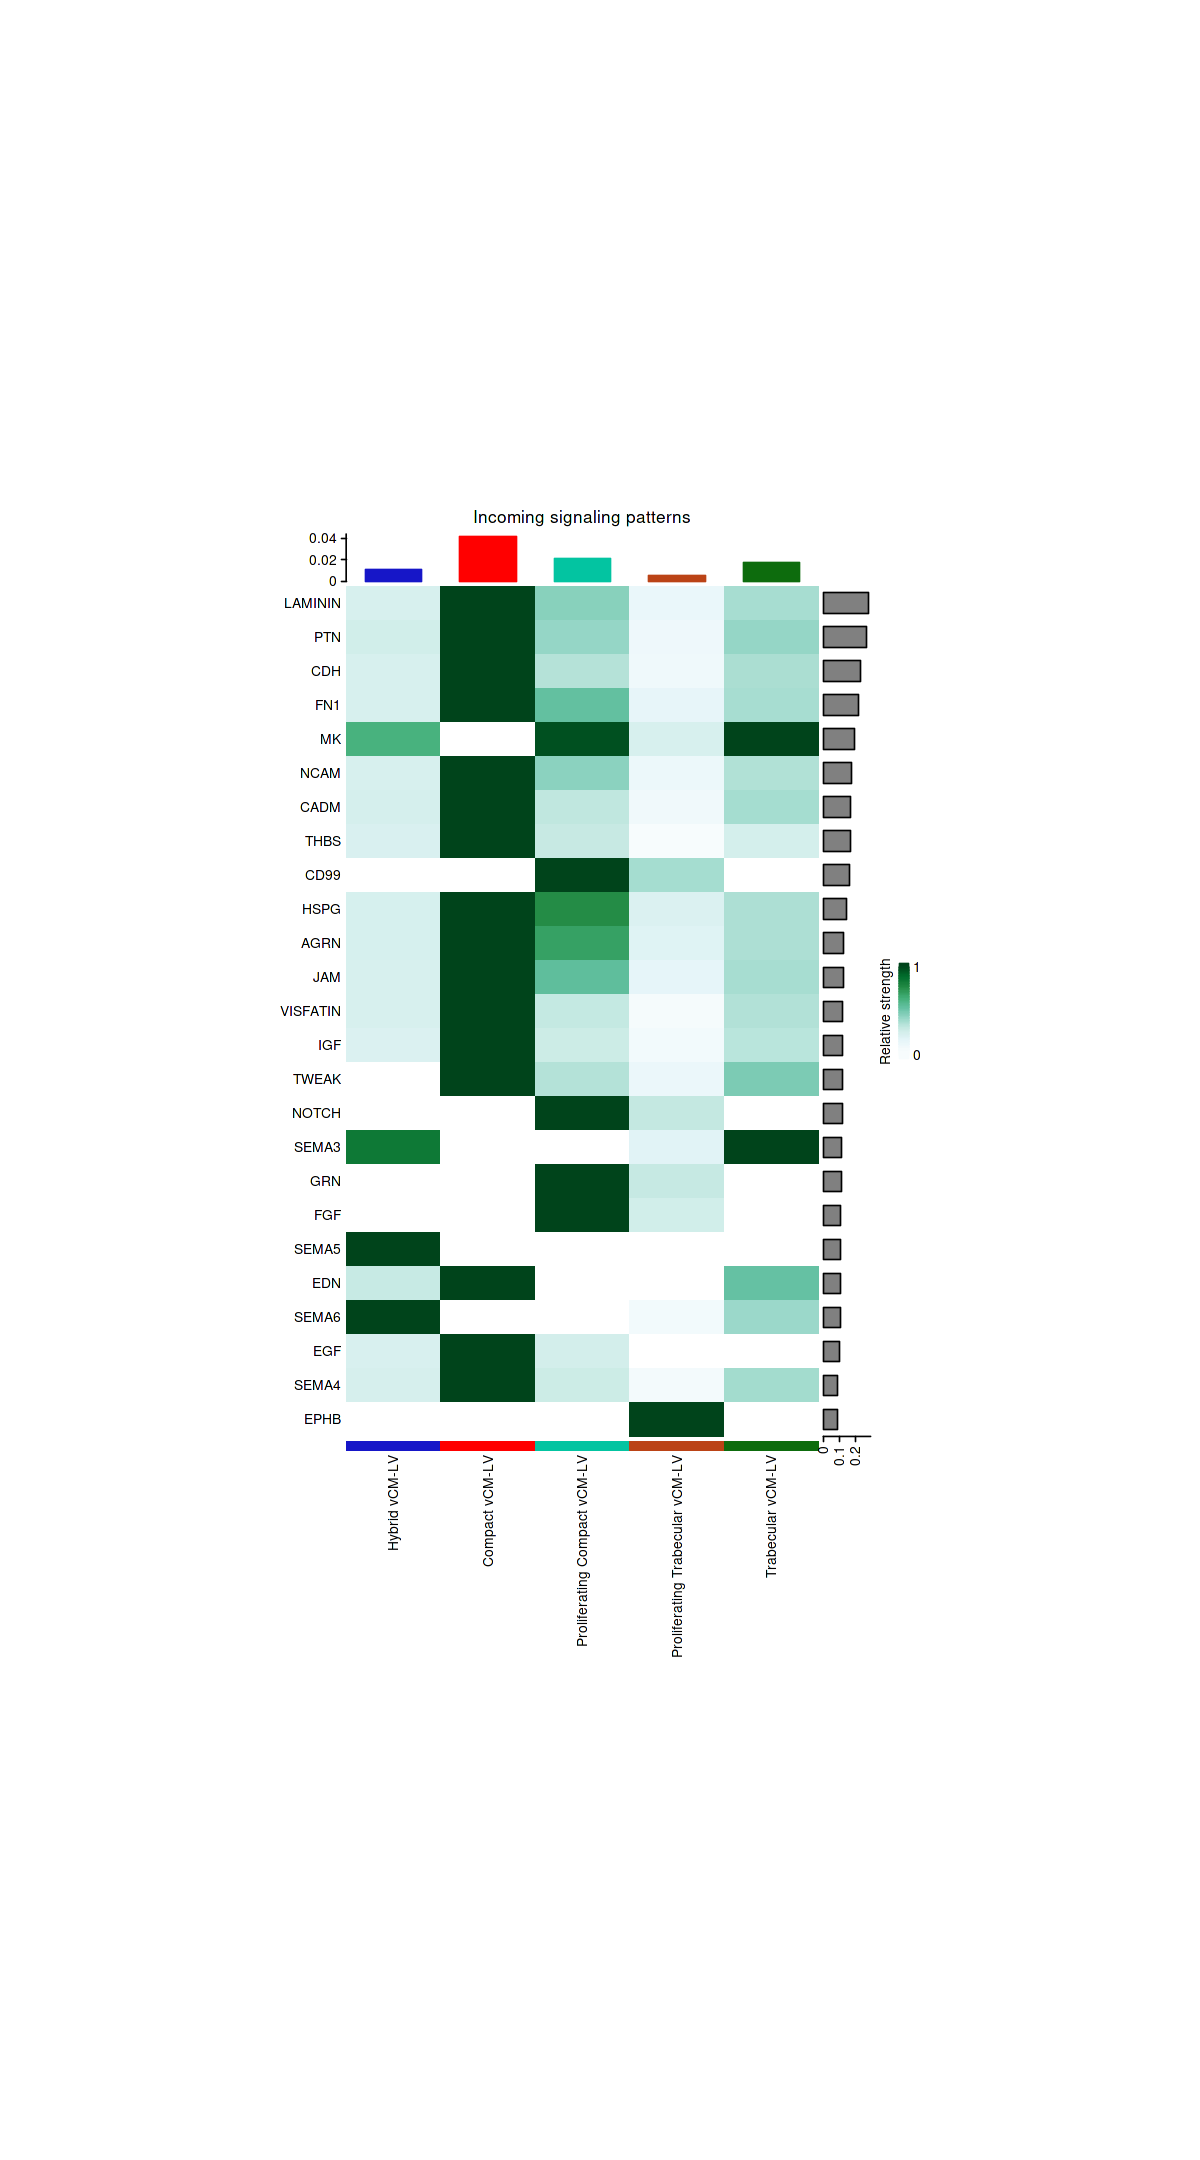

In [20]:
w = 10
h = 18 
options(repr.plot.width = w, repr.plot.height = h)
celltypes = c('Hybrid vCM-LV','Compact vCM-LV','Proliferating Compact vCM-LV',
              'Proliferating Trabecular vCM-LV','Trabecular vCM-LV')
ht1 = subset_netAnalysis_signalingRole_heatmap(cellchat_mid_lv, celltypes=celltypes, pattern = "incoming", width=w, height=h,
                                               color.use = celltype_vent_color[levels(cellchat_mid_lv@idents)[levels(cellchat_mid_lv@idents) %in% celltypes]])
ht1
options(repr.plot.width = 7, repr.plot.height = 7)

pdf('../figures/Ext_Dat_Fig10/cellchat_mid_lv_centrality_heatmap_incoming_cm.pdf', width=w, height=h)
ht1 
dev.off()


In [21]:
saveRDS(cellchat_mid_lv, '../data/cellchat/cellchat_mid_lv.rds')
# saveRDS(cellchat_mid_lv, '../data/cellchat/cellchat_mid_lv.rds')


# Outer-LV

Repeat analysis for Outer-LV community.

In [22]:
# Include cell types that represent at least 3.5% of the community in the MERFISH data
community_celltypes = c('Compact vCM-LV', 'Proliferating Compact vCM-LV', 'VE', 'Pericyte', 'Compact vFibro', 'Epicardial')

cellchat_outer_lv = createCellChat(object = subset(in_vivo, subset = merfish_vent_to_scrnaseq_label %in% community_celltypes),
                                   group.by = "merfish_vent_to_scrnaseq_label")


Create a CellChat object from a Seurat object



The `data` slot in the default assay is used. The default assay is RNA 
The `meta.data` slot in the Seurat object is used as cell meta information 


Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  Compact vCM-LV Compact vFibro Epicardial Pericyte Proliferating Compact vCM-LV VE 


In [23]:
CellChatDB <- CellChatDB.human 
# Add missing NRG1 - ERBB2 interaction to CellChat database
CellChatDB$interaction['NRG1_ERBB2',] = c('NRG1_ERBB2','NRG','NRG1','ERBB2','','','','','KEGG: hsa04012','Secreted Signaling','NRG1 - ERBB2')
CellChatDB.use = CellChatDB 
cellchat_outer_lv@DB <- CellChatDB.use


In [24]:
cellchat_outer_lv <- subsetData(cellchat_outer_lv)
cellchat_outer_lv <- identifyOverExpressedGenes(cellchat_outer_lv)
cellchat_outer_lv <- identifyOverExpressedInteractions(cellchat_outer_lv)
cellchat_outer_lv <- computeCommunProb(cellchat_outer_lv, population.size=TRUE)
cellchat_outer_lv <- filterCommunication(cellchat_outer_lv)
cellchat_outer_lv <- computeCommunProbPathway(cellchat_outer_lv)
cellchat_outer_lv <- aggregateNet(cellchat_outer_lv)
cellchat_outer_lv <- netAnalysis_computeCentrality(cellchat_outer_lv, slot.name = "netP") 


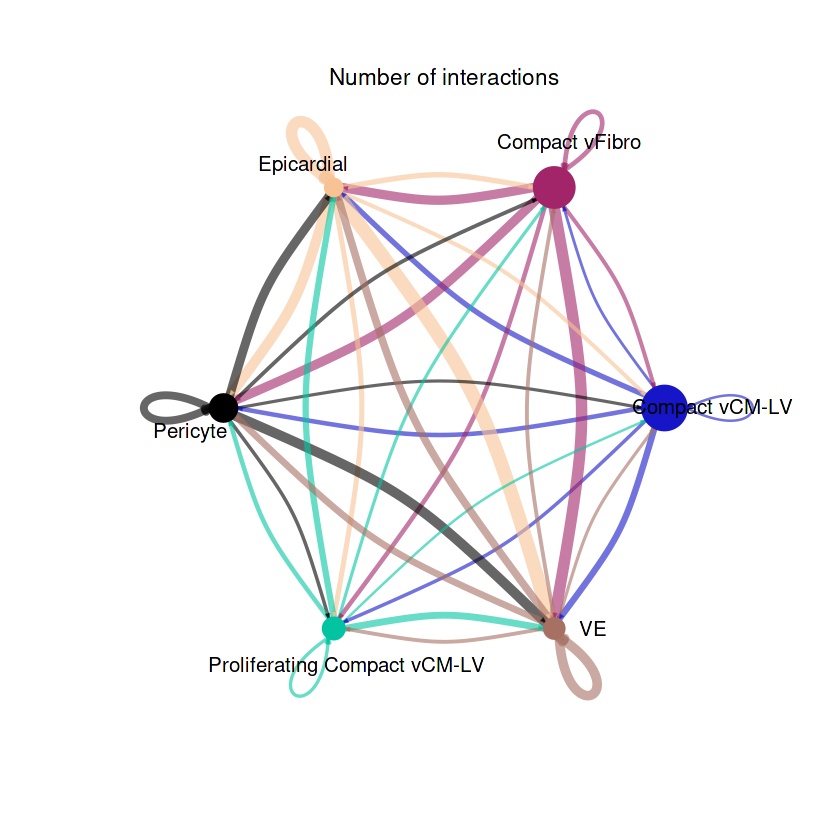

Saving 6.67 x 6.67 in image



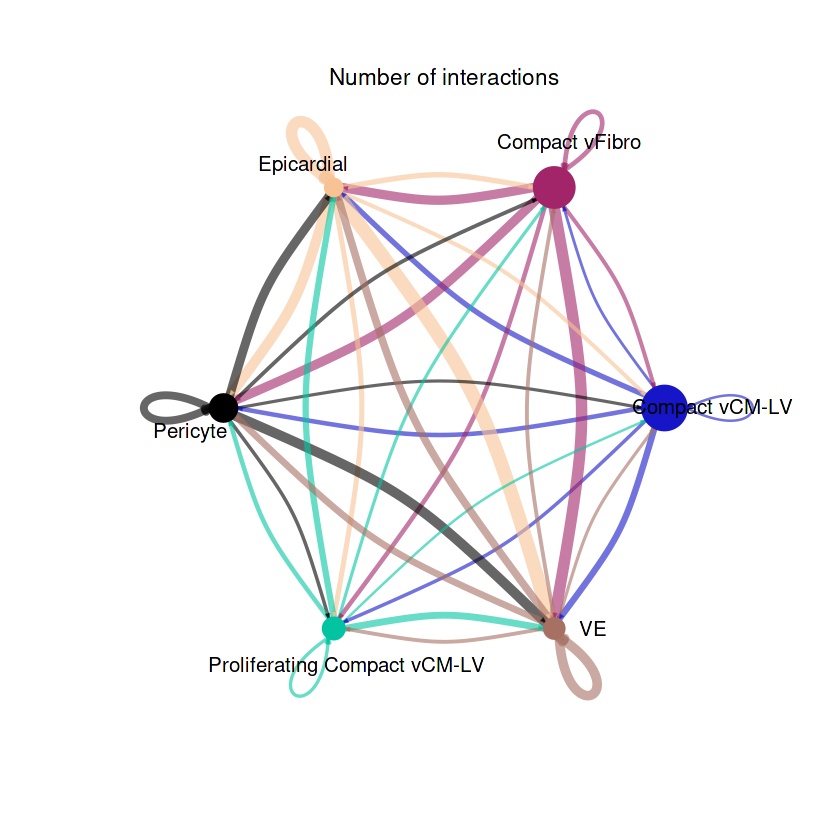

In [25]:
groupSize <- as.numeric(table(cellchat_outer_lv@idents))

netVisual_circle(cellchat_outer_lv@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Number of interactions", color.use = celltype_vent_color[levels(cellchat_outer_lv@idents)])
ggsave('../figures/Ext_Dat_Fig9/cellchat_outer_lv_n_inter.pdf')


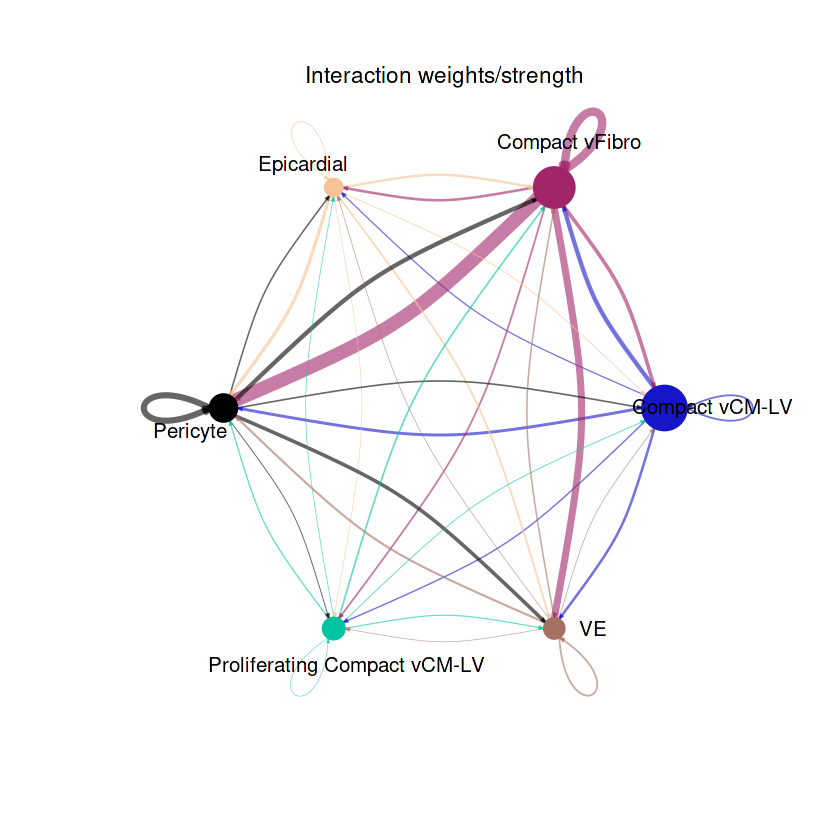

Saving 6.67 x 6.67 in image



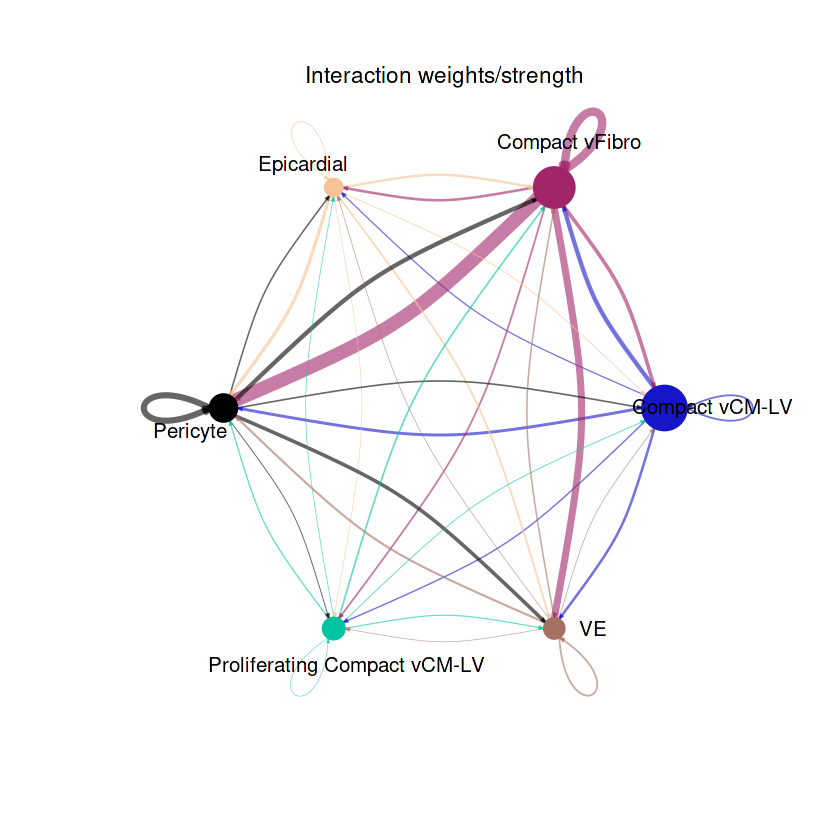

In [26]:
netVisual_circle(cellchat_outer_lv@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Interaction weights/strength", color.use = celltype_vent_color[levels(cellchat_outer_lv@idents)])
ggsave('../figures/Fig4/cellchat_outer_lv_inter_weights.pdf')


PNG 
  2

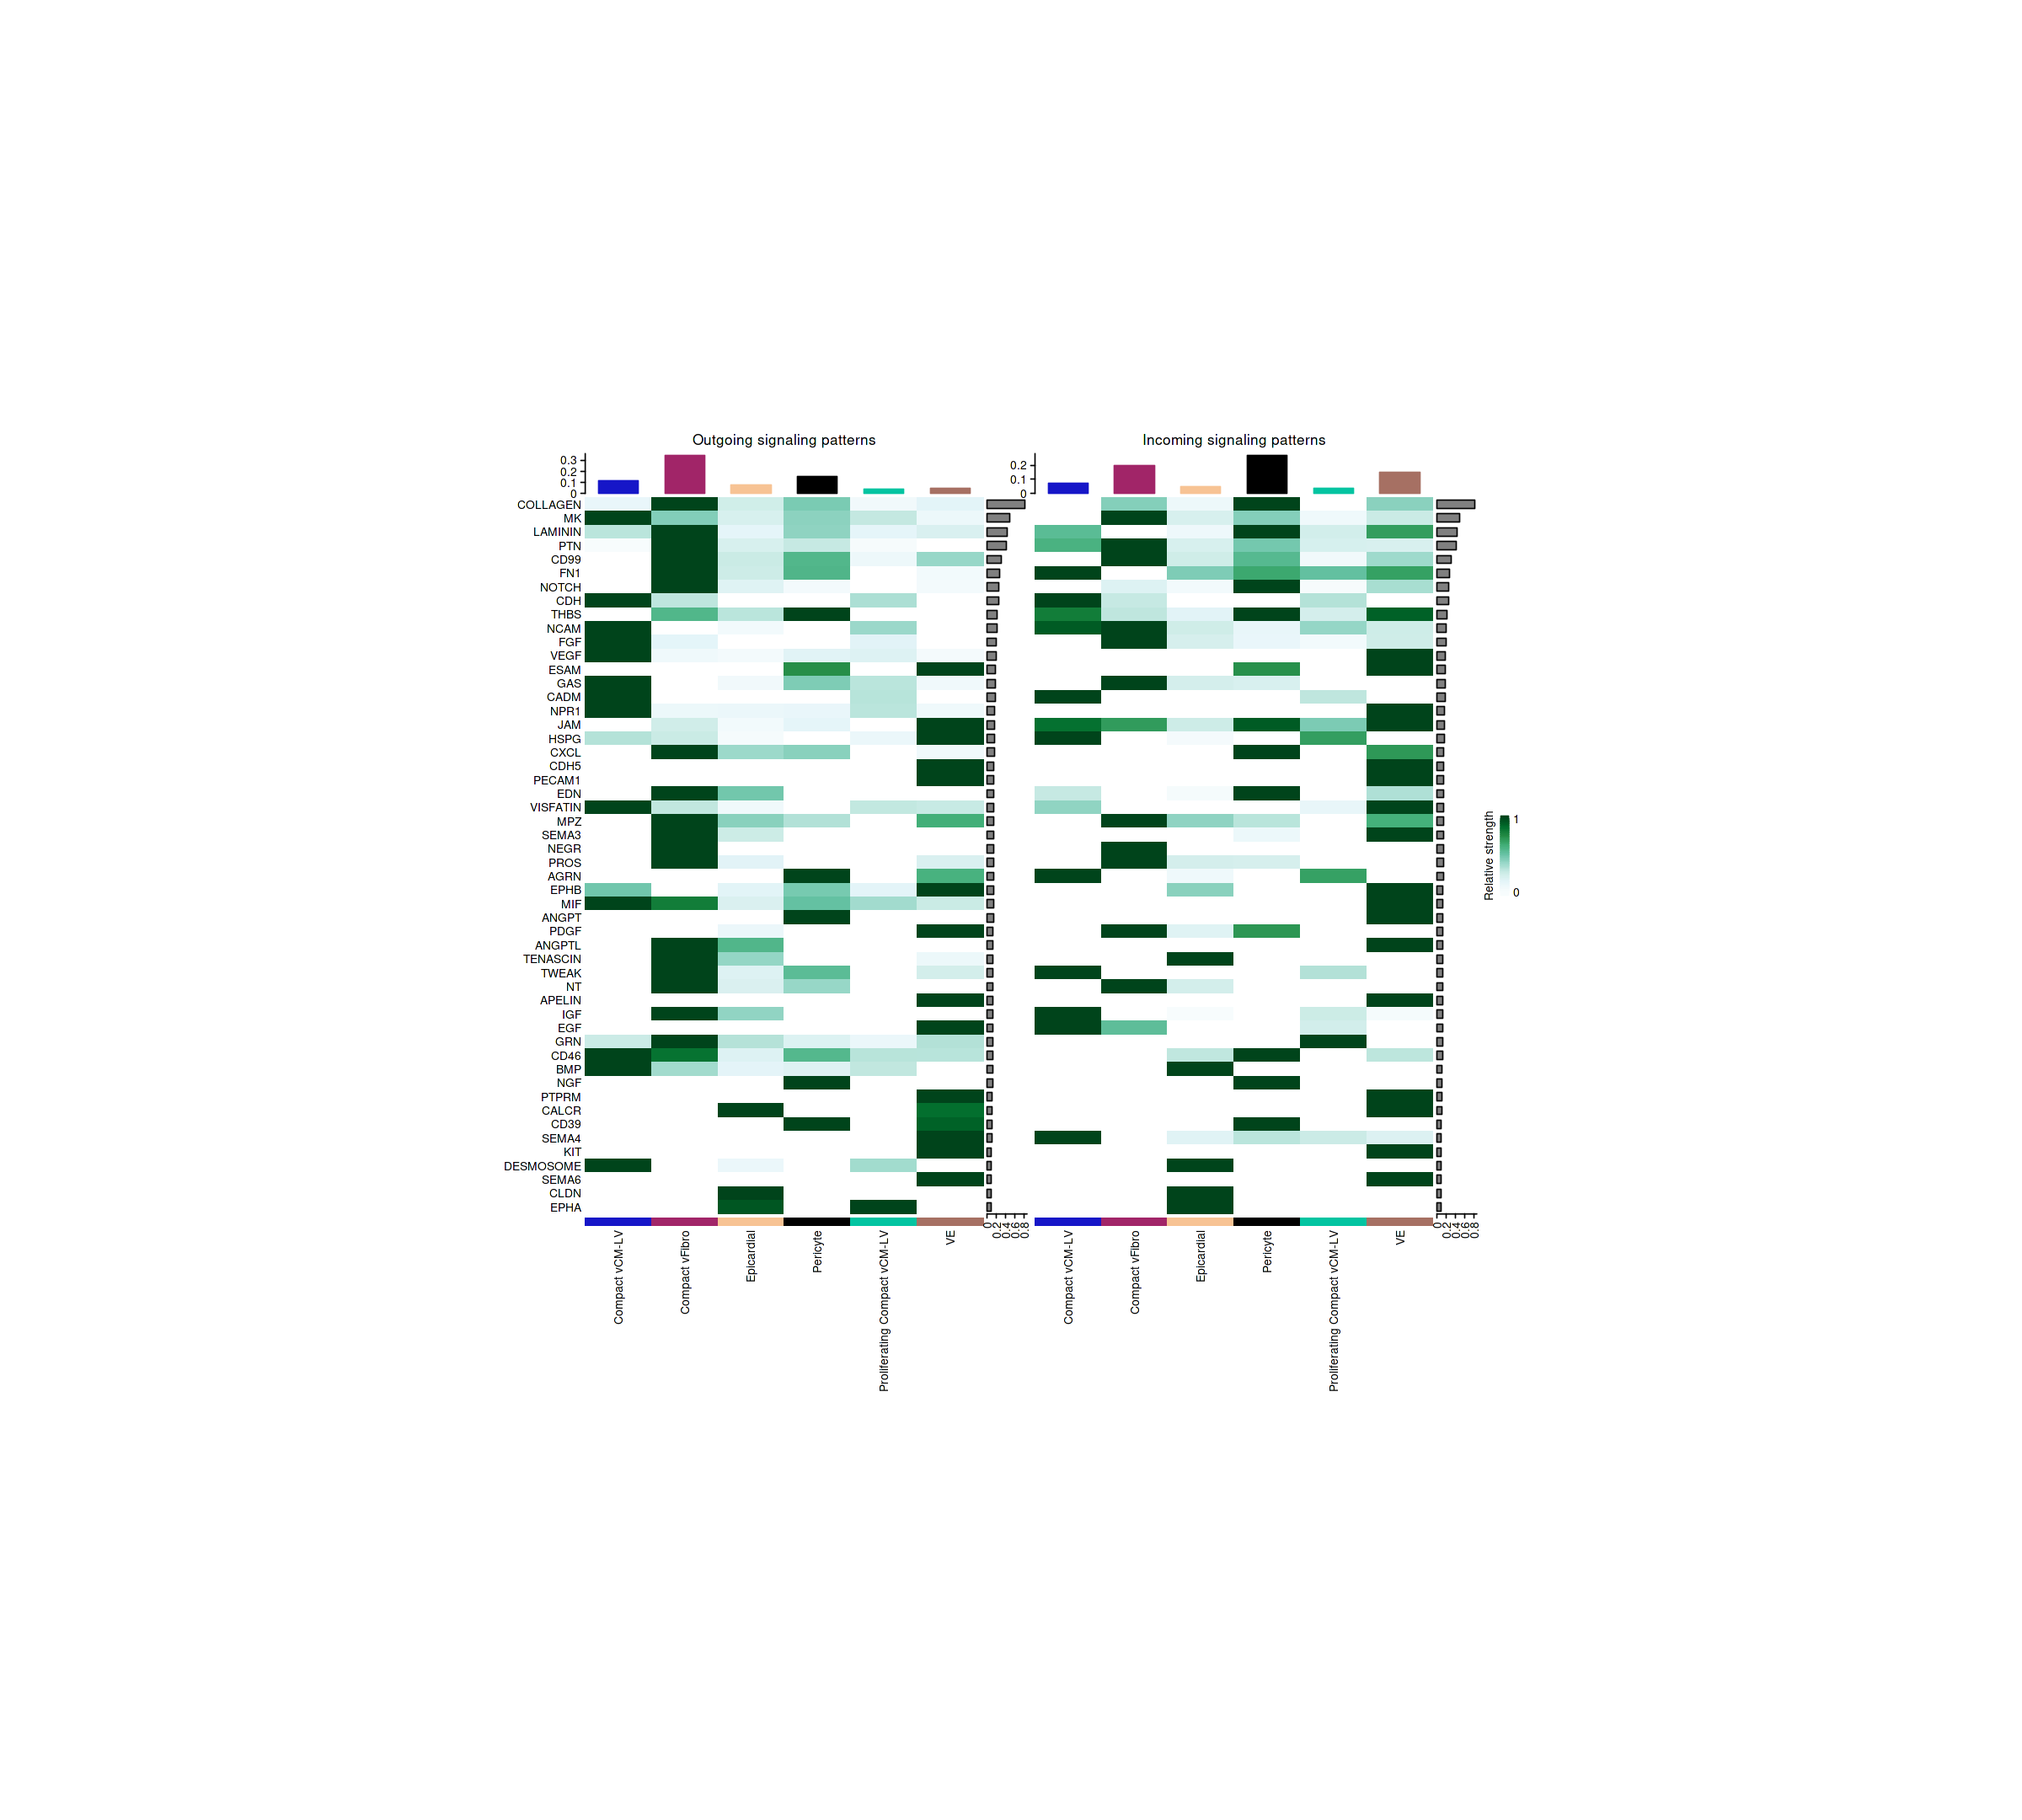

In [27]:
# Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
w = 10
h = 18 
ht1 <- netAnalysis_signalingRole_heatmap(cellchat_outer_lv, pattern = "outgoing", width=w, height=h, 
                                         color.use = celltype_vent_color[levels(cellchat_outer_lv@idents)])
ht2 <- netAnalysis_signalingRole_heatmap(cellchat_outer_lv, pattern = "incoming", width=w, height=h, 
                                         color.use = celltype_vent_color[levels(cellchat_outer_lv@idents)])

options(repr.plot.width = 2*w, repr.plot.height = h)
ht1 + ht2
options(repr.plot.width = 7, repr.plot.height = 7)

pdf(paste0('../figures/Ext_Dat_Fig9/cellchat_outer_lv_centrality_heatmap.pdf'), width=2*w, height=h)
ht1 + ht2
dev.off()


PNG 
  2

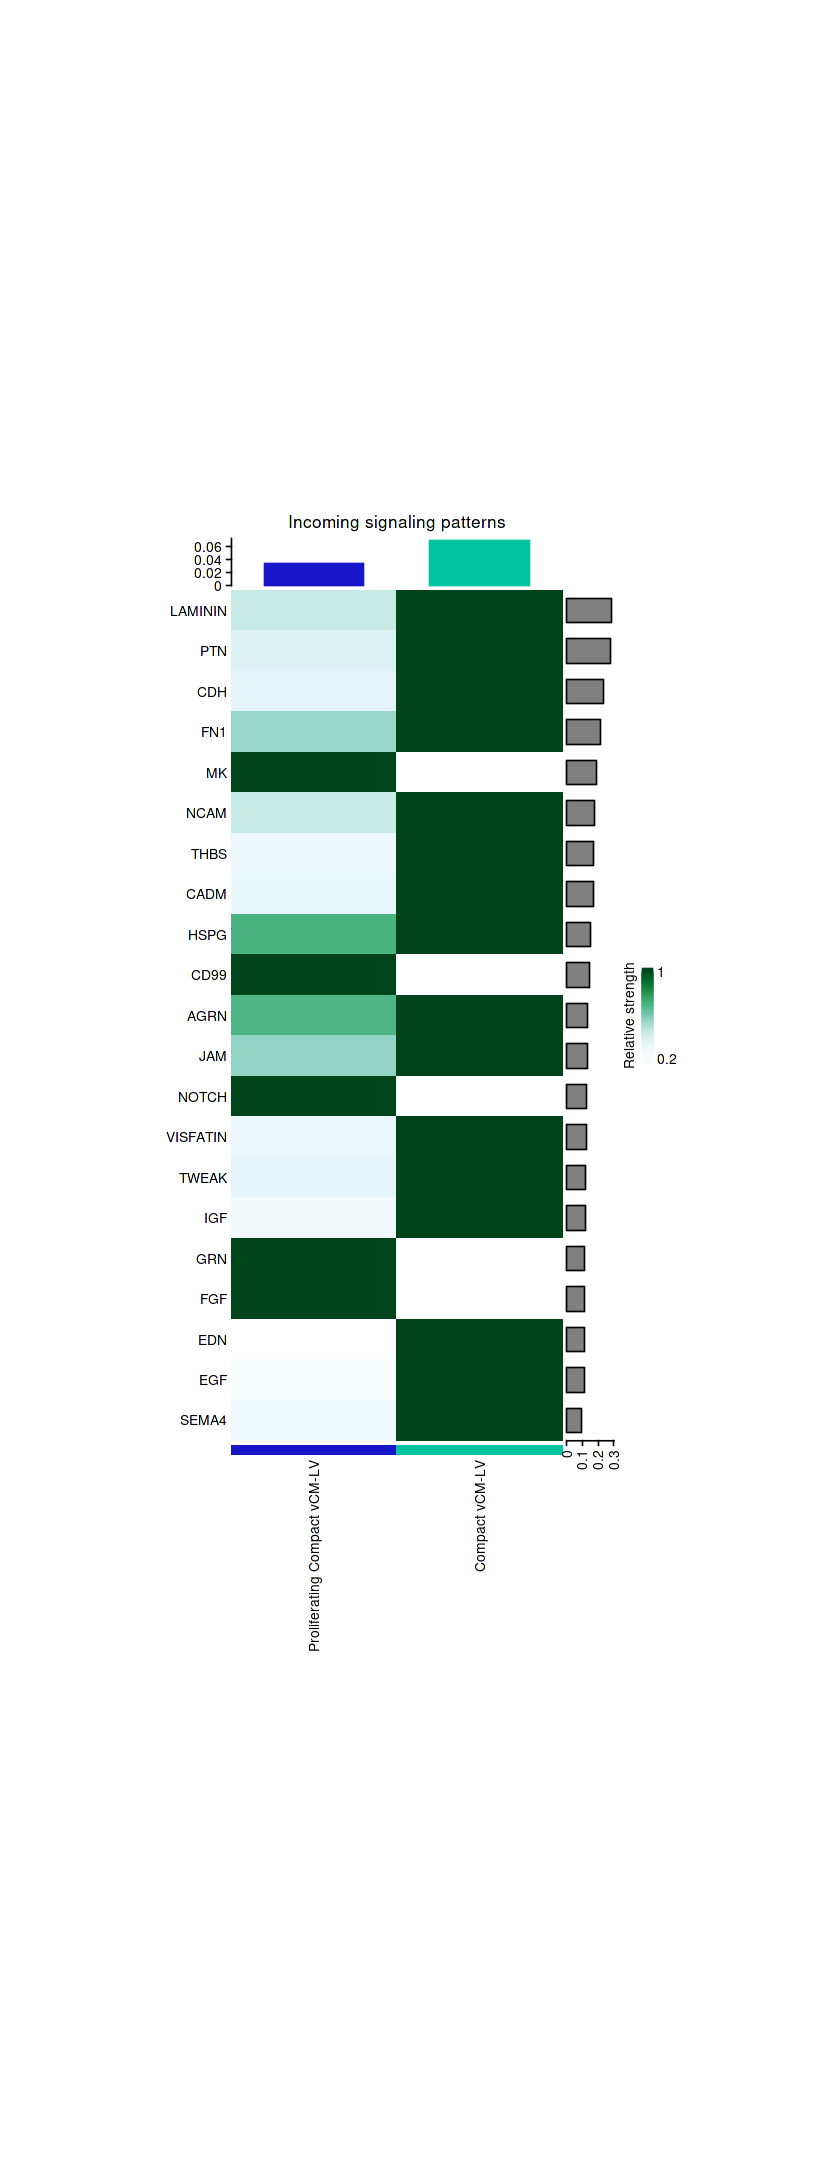

In [28]:
w = 7
h = 18 
options(repr.plot.width = w, repr.plot.height = h)
celltypes = c('Proliferating Compact vCM-LV','Compact vCM-LV')
ht1 = subset_netAnalysis_signalingRole_heatmap(cellchat_outer_lv, celltypes=celltypes, pattern = "incoming", width=w, height=h,
                                               color.use = celltype_vent_color[levels(cellchat_outer_lv@idents)[levels(cellchat_outer_lv@idents) %in% celltypes]])
ht1
options(repr.plot.width = 7, repr.plot.height = 7)

pdf('../figures/Ext_Dat_Fig10/cellchat_outer_lv_centrality_heatmap_incoming_cm.pdf', width=w, height=h)
ht1 
dev.off()


In [29]:
saveRDS(cellchat_outer_lv, '../data/cellchat/cellchat_outer_lv.rds')
# saveRDS(cellchat_outer_lv, '../data/cellchat/cellchat_outer_lv.rds')


# Identify community specific interactions

In [21]:
# Load community-specific CellChat objects (if needed)
cellchat_inner_lv = readRDS('../data/cellchat/cellchat_inner_lv.rds')
cellchat_mid_lv = readRDS('../data/cellchat/cellchat_mid_lv.rds')
cellchat_outer_lv = readRDS('../data/cellchat/cellchat_outer_lv.rds')


Identify which interactions (received by cardiomyocytes) are specific to each community, and which are shared.

In [30]:
thresh = 0.01 # p-value threshold

# Pull out all significant (pval < 0.01) interactions (received by CMs) in the Inner/Mid/Outer-LV communities
inner_inc_inter_cm = unique(c(rownames(cellchat_inner_lv@LR$LRsig)[apply(cellchat_inner_lv@net$pval[,'Trabecular vCM-LV',],2,min) < thresh],
                             rownames(cellchat_inner_lv@LR$LRsig)[apply(cellchat_inner_lv@net$pval[,'Proliferating Trabecular vCM-LV',],2,min) < thresh]))
mid_inc_inter_cm = unique(c(rownames(cellchat_mid_lv@LR$LRsig)[apply(cellchat_mid_lv@net$pval[,'Trabecular vCM-LV',],2,min) < thresh],
                               rownames(cellchat_mid_lv@LR$LRsig)[apply(cellchat_mid_lv@net$pval[,'Proliferating Trabecular vCM-LV',],2,min) < thresh],
                               rownames(cellchat_mid_lv@LR$LRsig)[apply(cellchat_mid_lv@net$pval[,'Compact vCM-LV',],2,min) < thresh],
                               rownames(cellchat_mid_lv@LR$LRsig)[apply(cellchat_mid_lv@net$pval[,'Proliferating Compact vCM-LV',],2,min) < thresh],
                               rownames(cellchat_mid_lv@LR$LRsig)[apply(cellchat_mid_lv@net$pval[,'Hybrid vCM-LV',],2,min) < thresh]))
outer_inc_inter_cm = unique(c(rownames(cellchat_outer_lv@LR$LRsig)[apply(cellchat_outer_lv@net$pval[,'Compact vCM-LV',],2,min) < thresh],
                             rownames(cellchat_outer_lv@LR$LRsig)[apply(cellchat_outer_lv@net$pval[,'Proliferating Compact vCM-LV',],2,min) < thresh]))

# Store community interactions (received by CMs) in list
community_interactions = list('Inner-LV' = inner_inc_inter_cm,
                              'Mid-LV' = mid_inc_inter_cm,
                              'Outer-LV' = outer_inc_inter_cm)


## Venn diagram

Visualize specific / shared interactions (received by CMs).

Registered S3 methods overwritten by 'proxy':
  method               from    
  print.registry_field registry
  print.registry_entry registry



PNG 
  2

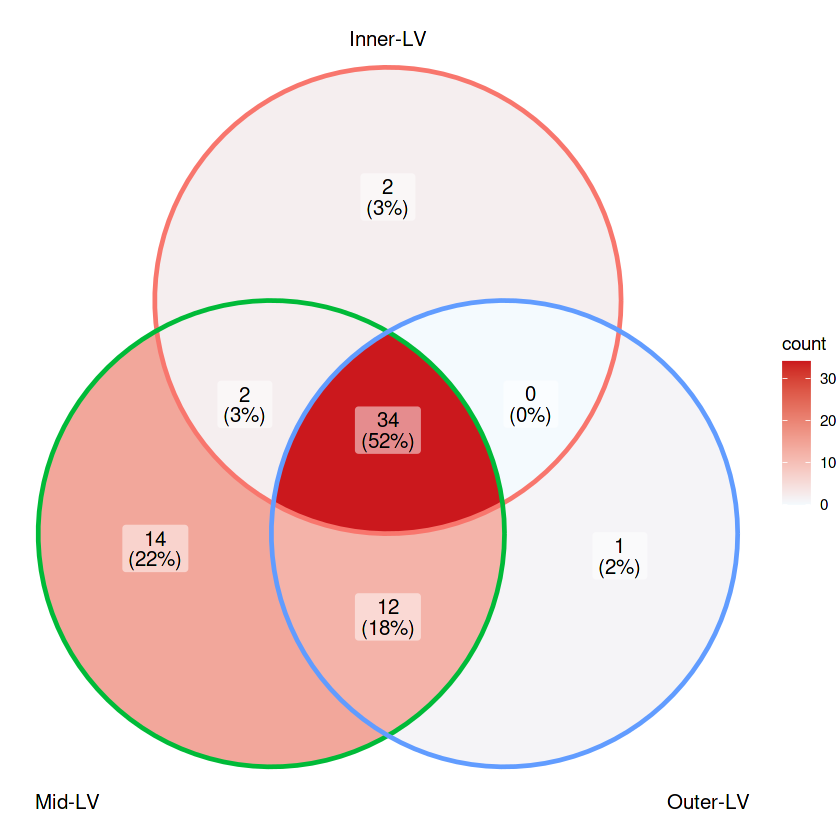

In [31]:
ggVennDiagram(community_interactions) + scale_fill_gradient(low = "#F4FAFE", high = "#cb181d")

pdf('../figures/Fig4/lv_community_incoming_inter_vcm_venn.pdf')
ggVennDiagram(community_interactions) + scale_fill_gradient(low = "#F4FAFE", high = "#cb181d")
dev.off()


In [32]:
inter_venn_df = data.frame(process_region_data(Venn(community_interactions)))
inter_venn_df$item = as.character(inter_venn_df$item)
inter_venn_df

# Write community interaction information to file
write.table(inter_venn_df, 
          '../data/cellchat/lv_community_incoming_inter_vcm_venn_info.txt',
          sep='\t', quote=F, row.names=F)


component id 
1 region    1  
2 region    2  
3 region    3  
4 region    12 
5 region    13 
6 region    23 
7 region    123
  item                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
1 c("DSC2_DSG2", "NRG1_ERBB2")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2 c("SEMA3C_NRP1_PLXNA2", "SEMA3C_NRP1_PLXNA4", "SEMA3D_NRP1_PLXNA2", "SEMA3D_NRP1_PLXNA4", "SEMA6A_PLXNA2", "SEMA6B_PLXNA2", "SEMA6A_PLXNA4", "SEMA6B_PLXNA4", "EFNB3_EPHB3", "SEMA3C_NRP1_PLXNA1", "SEMA3D_NRP1_PLXNA1", "SEMA5A_PLXNA1", "SEMA5B_PLXNA1", "SEMA6D_PLXNA1")                                                                                                                                                                                                                                                                              
3 PTN_SDC2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
4 c("EFNB1_EPHB3", "EFNB2_EPHB3")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
5 character(0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
6 c("NAMPT_INSR", "MDK_NCL", "THBS4_CD36", "THBS4_CD47", "SEMA4C_PLXNB2", "FGF1_FGFR1", "FGF7_FGFR1", "FGF9_FGFR1", "NCAM1_FGFR1", "DLL4_NOTCH2", "HBEGF_ERBB4", "HBEGF_ERBB2_ERBB4")                                                                                                                                                                                                                                                                                                                                                                      
7 c("IGF1_IGF1R", "TNFSF12_TNFRSF12A", "PTN_NCL", "EDN1_EDNRA", "LAMA2_ITGA7_ITGB1", "LAMA4_IT

## Interaction dot plots

For Inner-LV community.

Comparing communications on a single object 




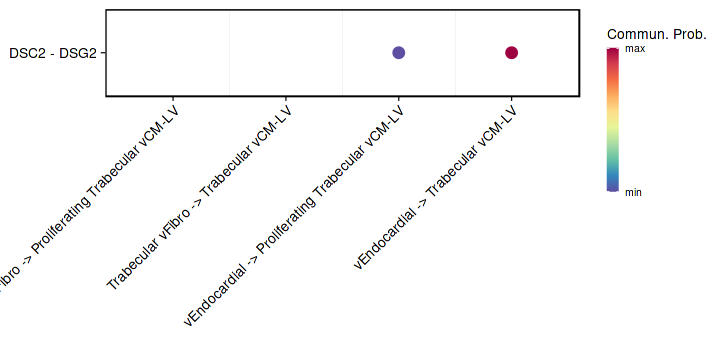

In [35]:
w = 6
h = 3 # all 
options(repr.plot.width = w, repr.plot.height = h)

netVisual_bubble(cellchat_inner_lv, angle.x = 45, 
                 sources.use = c('vEndocardial', 'Trabecular vFibro'),
                 targets.use = c('Proliferating Trabecular vCM-LV','Trabecular vCM-LV'),
                 pairLR.use = data.frame(interaction_name = inter_venn_df[inter_venn_df$name=='Inner-LV', 'item']))
ggsave(paste0('../figures/Ext_Dat_Fig10/cellchat_inner_lv_inter_dotplot_incoming_cm.pdf'), width=w, height=h)


For Mid-LV community.

Comparing communications on a single object 




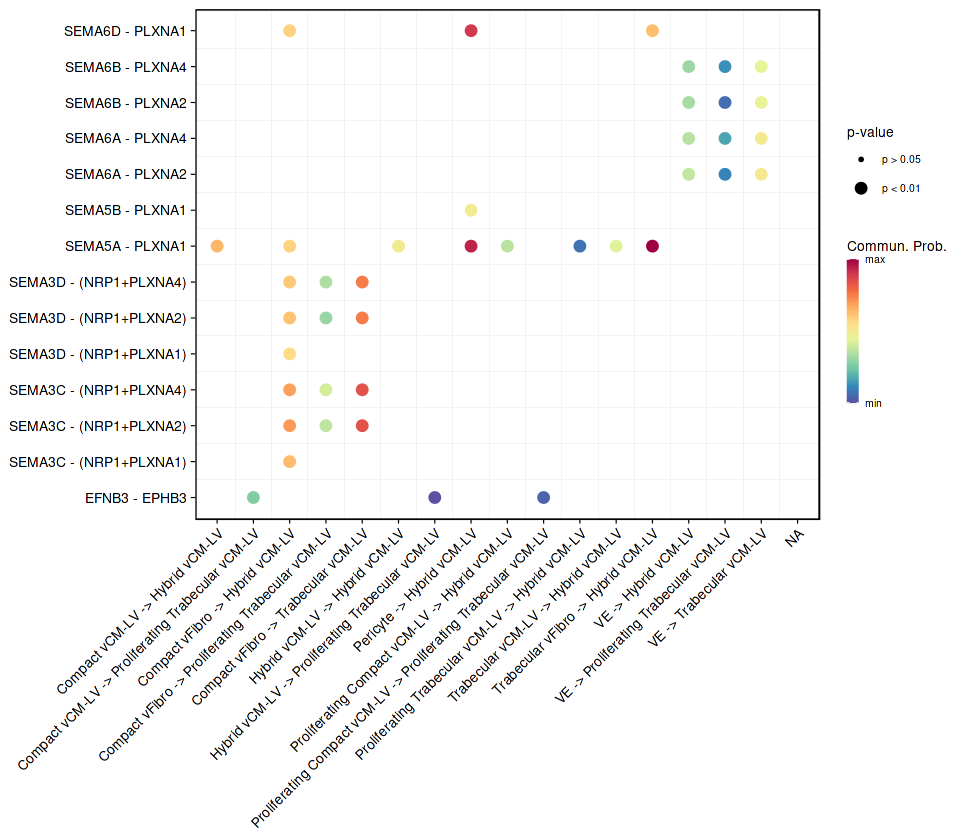

In [36]:
w = 8
h = 7
options(repr.plot.width = w, repr.plot.height = h)

netVisual_bubble(cellchat_mid_lv, angle.x = 45, 
                 targets.use = c('Hybrid vCM-LV','Compact vCM-LV','Proliferating Compact vCM-LV',
                                 'Proliferating Trabecular vCM-LV','Trabecular vCM-LV'),
                 pairLR.use = data.frame(interaction_name = eval(parse(text=inter_venn_df[inter_venn_df$name=='Mid-LV', 'item']))))
ggsave(paste0('../figures/Fig4/cellchat_mid_lv_inter_dotplot_incoming_cm.pdf'), width=w, height=h)


In [37]:
w = 6
h = 3 # all 
options(repr.plot.width = w, repr.plot.height = h)

netVisual_bubble(cellchat_mid_lv, angle.x = 45, 
                 sources.use = c('VE', 'Pericyte', 'Compact vFibro', 'Epicardial'),
                 targets.use = c('Compact vCM-LV','Proliferating Compact vCM-LV'),
                 pairLR.use = data.frame(interaction_name = eval(parse(text=inter_venn_df[inter_venn_df$name=='Outer-LV', 'item']))))
ggsave(paste0('../figures/Ext_Dat_Fig10/cellchat_inner_lv_inter_dotplot_incoming_cm.pdf'), width=w, height=h)


Comparing communications on a single object 




ERROR: Error in eval(parse(text = inter_venn_df[inter_venn_df$name == "Outer-LV", : object 'PTN_SDC2' not found


There are no Outer-LV community specific interactions.

Visualize non-community specific / shared interactions.

In [ ]:
common_interactions = c()
for (n in inter_venn_df$name){
    # don't include community-specific interactions
    if (n %in% c("Inner-LV", "Mid-LV", "Outer-LV")){
        next
    }
    interactions = inter_venn_df[inter_venn_df$name==n, 'item']
    # different ways to parse string for 1 / >1 interactions
    if (str_count(interactions, "_")==1){
        common_interactions = c(common_interactions, inter_venn_df[inter_venn_df$name==n, 'item'])
    } else if ((str_count(interactions, "_")>1)){
        common_interactions = c(common_interactions, eval(parse(text=inter_venn_df[inter_venn_df$name==n, 'item'])))
    }
}


In [ ]:
w = 16
h = 12
options(repr.plot.width = w, repr.plot.height = h)

netVisual_bubble(cellchat_mid_lv, angle.x = 45, 
                 targets.use = c('Hybrid vCM-LV','Compact vCM-LV','Proliferating Compact vCM-LV',
                                 'Proliferating Trabecular vCM-LV','Trabecular vCM-LV'),
                 pairLR.use = data.frame(interaction_name = common_interactions))
ggsave(paste0('../figures/Ext_Dat_Fig10/cellchat_mid_lv_inter_dotplot_incoming_cm_common.pdf'), width=w, height=h)
